Using device: cuda


100%|██████████| 562M/562M [01:05<00:00, 8.61MB/s]


Training model...
Epoch 1, Loss: 0.5370
Epoch 2, Loss: 0.2574
Epoch 3, Loss: 0.2097
Epoch 4, Loss: 0.1793
Epoch 5, Loss: 0.1548
Epoch 6, Loss: 0.1341
Epoch 7, Loss: 0.1179
Epoch 8, Loss: 0.1031
Epoch 9, Loss: 0.0898
Epoch 10, Loss: 0.0802
Test Accuracy: 92.82%


<ipython-input-1-eb16ead19d1b>:166: UserWarning: Using a target size (torch.Size([1, 64, 24, 24])) that is different to the input size (torch.Size([64, 24, 24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  perceptual_loss = F.mse_loss(reconstructed_features, target_features) * 0.5


Step 0 | Total Loss: 1.5222 | CE: 1.4418 | L2: 0.0069 | Perceptual: 0.0372 | TV: 0.0364
Step 100 | Total Loss: 0.0468 | CE: 0.0010 | L2: 0.0056 | Perceptual: 0.0343 | TV: 0.0058
Step 200 | Total Loss: 0.0445 | CE: 0.0008 | L2: 0.0050 | Perceptual: 0.0338 | TV: 0.0049
Step 300 | Total Loss: 0.0424 | CE: 0.0006 | L2: 0.0044 | Perceptual: 0.0332 | TV: 0.0042
Step 400 | Total Loss: 0.0411 | CE: 0.0006 | L2: 0.0039 | Perceptual: 0.0327 | TV: 0.0038
Step 500 | Total Loss: 0.0399 | CE: 0.0006 | L2: 0.0035 | Perceptual: 0.0322 | TV: 0.0036
Step 600 | Total Loss: 0.0386 | CE: 0.0006 | L2: 0.0031 | Perceptual: 0.0315 | TV: 0.0035
Step 700 | Total Loss: 0.0375 | CE: 0.0006 | L2: 0.0027 | Perceptual: 0.0308 | TV: 0.0033
Step 800 | Total Loss: 0.0356 | CE: 0.0004 | L2: 0.0024 | Perceptual: 0.0294 | TV: 0.0034
Step 900 | Total Loss: 0.0341 | CE: 0.0004 | L2: 0.0022 | Perceptual: 0.0282 | TV: 0.0032
Step 1000 | Total Loss: 0.0329 | CE: 0.0004 | L2: 0.0020 | Perceptual: 0.0273 | TV: 0.0032
Step 1100 |

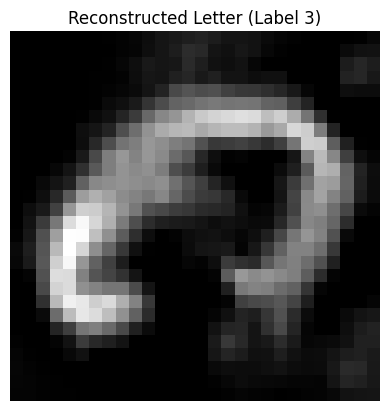


🔍 Prediction Analysis:
Predicted class: 3
Confidence in target class (3): 0.9997

📊 Similarity Metrics:
MSE (pixel-wise): 0.0815
SSIM (structural): 0.2930


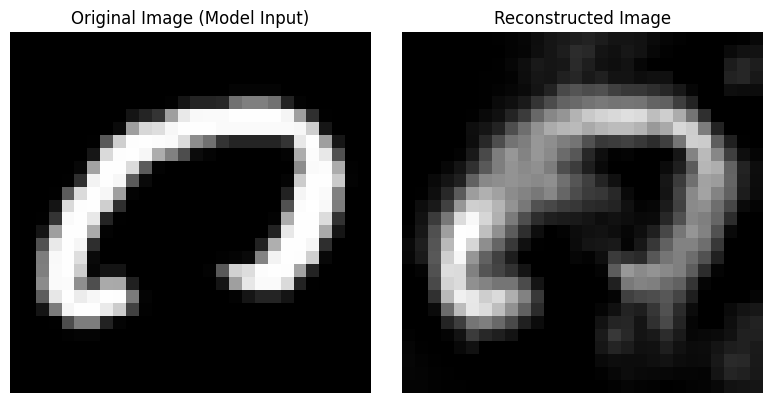

In [1]:
# ============================================
# 🔐 WHITE-BOX MODEL INVERSION ATTACK (EMNIST)
# ============================================

# 🛠️ TOOLCHAIN: PyTorch, torchvision, skimage, matplotlib
# 📚 DATASET: EMNIST (Letters A-Z)
# ============================================

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
import numpy as np
import os

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# -----------------------------------
# 1. Load EMNIST Letters Dataset
# -----------------------------------
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.EMNIST(root='./data', split='letters', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = datasets.EMNIST(root='./data', split='letters', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# -----------------------------------
# 2. Define a simple CNN model
# -----------------------------------
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 26)  # 26 classes (A-Z)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def get_features(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x

model = SimpleCNN().to(device)

# -----------------------------------
# 3. Train the model (if no saved model)
# -----------------------------------
model_path = 'emnist_cnn.pth'
if not os.path.exists(model_path):
    print("Training model...")
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()
    model.train()
    for epoch in range(10):  # Quick 3 epochs
        total_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = loss_fn(outputs, labels - 1)  # EMNIST labels start from 1
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")
    torch.save(model.state_dict(), model_path)
else:
    print("Loading existing model...")
    model.load_state_dict(torch.load(model_path, map_location=device))

model.eval()




# === ADD THIS PART to evaluate on the test set ===
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        predicted = outputs.argmax(dim=1)
        correct += (predicted == (labels - 1)).sum().item()  # labels - 1 because EMNIST labels start at 1
        total += labels.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy*100:.2f}%")
# === END of the added part ===


# -----------------------------------
# 4. White-Box Inversion Attack
# -----------------------------------
# Target: Letter 'C' (Label 3 in EMNIST "letters")
target_label = 3
target_class = torch.tensor([target_label - 1], dtype=torch.long).to(device)

# Initialize with mean image of the target letter + noise
mean_img = torch.zeros((1, 1, 28, 28), device=device)
count = 0
for img, label in train_dataset:
    if label == target_label:
        mean_img += img.to(device)
        count += 1
mean_img /= count
reconstructed_img = (mean_img + torch.randn_like(mean_img) * 0.1).requires_grad_(True)

# Optimizer and scheduler
optimizer = optim.AdamW([reconstructed_img], lr=0.005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=800, gamma=0.7)
loss_fn = nn.CrossEntropyLoss()

# Total Variation Loss
def tv_loss(img):
    h_var = torch.sum((img[:, :, 1:, :] - img[:, :, :-1, :])**2)
    w_var = torch.sum((img[:, :, :, 1:] - img[:, :, :, :-1])**2)
    return h_var + w_var

# Gaussian smoothing
def gaussian_blur(img):
    kernel = torch.tensor([[1, 2, 1], [2, 4, 2], [1, 2, 1]], dtype=torch.float32, device=device) / 16
    kernel = kernel.view(1, 1, 3, 3)
    return F.conv2d(img, kernel, padding=1)

# Get real features of the target letter
target_image = None
for img, label in train_dataset:
    if label == target_label:
        target_image = img
        break

if target_image is None:
    raise ValueError(f"Target label {target_label} not found in dataset.")

target_image = target_image.unsqueeze(0).to(device)
target_features = model.get_features(target_image)

# -----------------------------------
# Inversion Loop
# -----------------------------------
for step in range(2500):
    optimizer.zero_grad()
    output = model(reconstructed_img)
    loss = loss_fn(output, target_class)
    l2_loss = torch.sum(reconstructed_img ** 2) * 0.0001
    reconstructed_features = model.get_features(reconstructed_img)[0]
    perceptual_loss = F.mse_loss(reconstructed_features, target_features) * 0.5
    tv = tv_loss(reconstructed_img) * 0.001
    total_loss = loss + l2_loss + perceptual_loss + tv
    total_loss.backward(retain_graph=True)
    torch.nn.utils.clip_grad_norm_([reconstructed_img], 5.0)
    optimizer.step()
    scheduler.step()

    with torch.no_grad():
        reconstructed_img.clamp_(0, 1)
        if step % 50 == 0:
            reconstructed_img.copy_(gaussian_blur(reconstructed_img).clamp_(0, 1))

    if step % 100 == 0:
        print(f"Step {step} | Total Loss: {total_loss.item():.4f} | CE: {loss.item():.4f} | "
              f"L2: {l2_loss.item():.4f} | Perceptual: {perceptual_loss.item():.4f} | TV: {tv.item():.4f}")
        plt.imshow(reconstructed_img.squeeze().detach().cpu(), cmap='gray')
        plt.title(f"Step {step}")
        plt.axis('off')
        plt.savefig(f"emnist_reconstructed_step_{step}.png")
        plt.close()

# -----------------------------------
# Final Visualization
# -----------------------------------
plt.imshow(reconstructed_img.squeeze().detach().cpu(), cmap='gray')
plt.title(f"Reconstructed Letter (Label {target_label})")
plt.axis('off')
plt.savefig('emnist_reconstructed_final.png')
plt.show()

# -----------------------------------
# Evaluation
# -----------------------------------
with torch.no_grad():
    probs = F.softmax(model(reconstructed_img), dim=1)
    confidence = probs[0, target_label - 1].item()
    predicted_class = torch.argmax(probs).item()

print(f"\n🔍 Prediction Analysis:")
print(f"Predicted class: {predicted_class + 1}")
print(f"Confidence in target class ({target_label}): {confidence:.4f}")

original_np = target_image.squeeze().cpu().numpy()
reconstructed_np = reconstructed_img.squeeze().detach().cpu().numpy()

mse_val = np.mean((original_np - reconstructed_np) ** 2)
ssim_val = ssim(original_np, reconstructed_np, data_range=1.0)

print(f"\n📊 Similarity Metrics:")
print(f"MSE (pixel-wise): {mse_val:.4f}")
print(f"SSIM (structural): {ssim_val:.4f}")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(target_image.squeeze().cpu().numpy(), cmap='gray')
axes[0].set_title("Original Image (Model Input)")
axes[0].axis('off')

axes[1].imshow(reconstructed_img.squeeze().detach().cpu().numpy(), cmap='gray')
axes[1].set_title("Reconstructed Image")
axes[1].axis('off')

plt.tight_layout()
plt.savefig('emnist_comparison.png')
plt.show()



Performing inversion attack for class 1...


<ipython-input-2-dad123bc5565>:110: UserWarning: Using a target size (torch.Size([1, 64, 24, 24])) that is different to the input size (torch.Size([64, 24, 24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  perceptual_loss = F.mse_loss(reconstructed_features, target_features) * 0.5


Step 0 | Total Loss: 0.8690 | CE: 0.7866 | L2: 0.0077 | Perceptual: 0.0409 | TV: 0.0337
Step 100 | Total Loss: 0.0519 | CE: 0.0005 | L2: 0.0069 | Perceptual: 0.0390 | TV: 0.0054
Step 200 | Total Loss: 0.0499 | CE: 0.0005 | L2: 0.0067 | Perceptual: 0.0383 | TV: 0.0044
Step 300 | Total Loss: 0.0489 | CE: 0.0003 | L2: 0.0064 | Perceptual: 0.0379 | TV: 0.0042
Step 400 | Total Loss: 0.0480 | CE: 0.0003 | L2: 0.0062 | Perceptual: 0.0374 | TV: 0.0042
Step 500 | Total Loss: 0.0472 | CE: 0.0003 | L2: 0.0059 | Perceptual: 0.0368 | TV: 0.0042
Step 600 | Total Loss: 0.0465 | CE: 0.0002 | L2: 0.0056 | Perceptual: 0.0364 | TV: 0.0042
Step 700 | Total Loss: 0.0456 | CE: 0.0002 | L2: 0.0054 | Perceptual: 0.0358 | TV: 0.0042
Step 800 | Total Loss: 0.0447 | CE: 0.0003 | L2: 0.0052 | Perceptual: 0.0350 | TV: 0.0042
Step 900 | Total Loss: 0.0446 | CE: 0.0003 | L2: 0.0050 | Perceptual: 0.0351 | TV: 0.0041
Step 1000 | Total Loss: 0.0444 | CE: 0.0003 | L2: 0.0048 | Perceptual: 0.0352 | TV: 0.0041
Step 1100 |

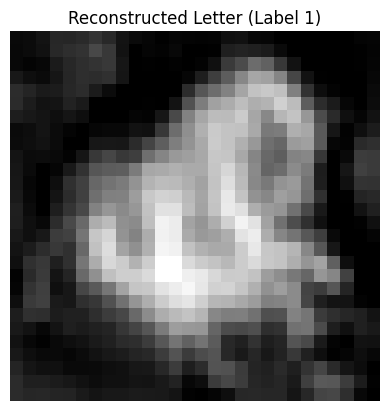


🔍 Prediction Analysis for class 1:
Predicted class: 1
Confidence in target class (1): 0.9996

📊 Similarity Metrics for class 1:
MSE (pixel-wise): 0.1046
SSIM (structural): 0.1622


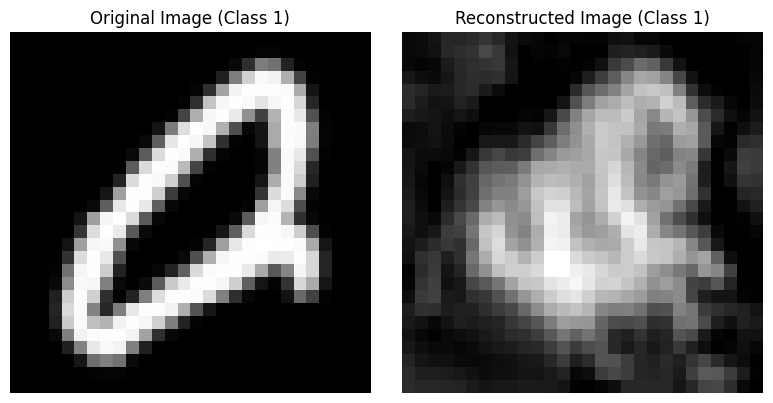


Performing inversion attack for class 2...
Step 0 | Total Loss: 2.9865 | CE: 2.8770 | L2: 0.0065 | Perceptual: 0.0671 | TV: 0.0359
Step 100 | Total Loss: 0.0745 | CE: 0.0006 | L2: 0.0057 | Perceptual: 0.0628 | TV: 0.0054
Step 200 | Total Loss: 0.0717 | CE: 0.0003 | L2: 0.0054 | Perceptual: 0.0613 | TV: 0.0047
Step 300 | Total Loss: 0.0701 | CE: 0.0002 | L2: 0.0052 | Perceptual: 0.0602 | TV: 0.0045
Step 400 | Total Loss: 0.0679 | CE: 0.0001 | L2: 0.0050 | Perceptual: 0.0584 | TV: 0.0044
Step 500 | Total Loss: 0.0657 | CE: 0.0001 | L2: 0.0049 | Perceptual: 0.0566 | TV: 0.0042
Step 600 | Total Loss: 0.0640 | CE: 0.0001 | L2: 0.0047 | Perceptual: 0.0552 | TV: 0.0040
Step 700 | Total Loss: 0.0623 | CE: 0.0002 | L2: 0.0045 | Perceptual: 0.0537 | TV: 0.0040
Step 800 | Total Loss: 0.0608 | CE: 0.0002 | L2: 0.0043 | Perceptual: 0.0523 | TV: 0.0040
Step 900 | Total Loss: 0.0609 | CE: 0.0002 | L2: 0.0042 | Perceptual: 0.0528 | TV: 0.0037
Step 1000 | Total Loss: 0.0603 | CE: 0.0002 | L2: 0.0040 |

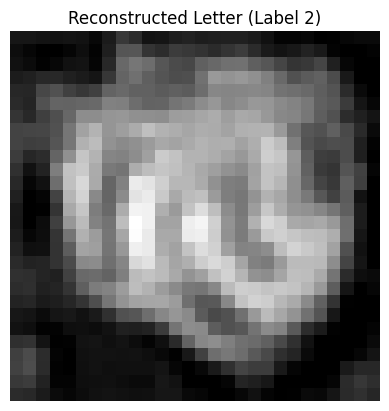


🔍 Prediction Analysis for class 2:
Predicted class: 2
Confidence in target class (2): 0.9995

📊 Similarity Metrics for class 2:
MSE (pixel-wise): 0.1052
SSIM (structural): 0.1195


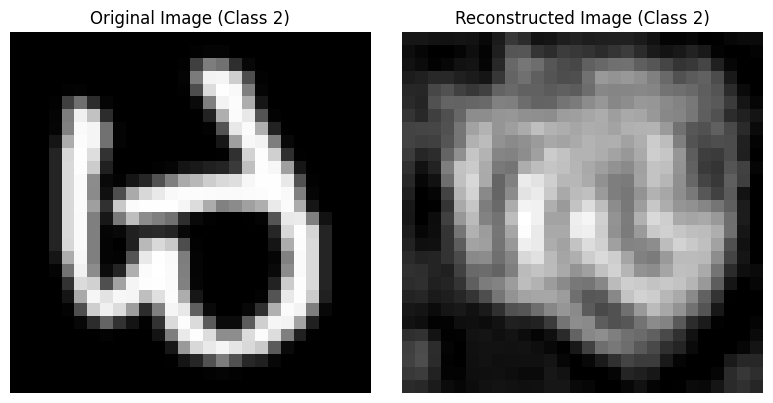


Performing inversion attack for class 3...
Step 0 | Total Loss: 3.0660 | CE: 2.9870 | L2: 0.0069 | Perceptual: 0.0358 | TV: 0.0364
Step 100 | Total Loss: 0.0453 | CE: 0.0009 | L2: 0.0057 | Perceptual: 0.0327 | TV: 0.0060
Step 200 | Total Loss: 0.0430 | CE: 0.0006 | L2: 0.0052 | Perceptual: 0.0321 | TV: 0.0050
Step 300 | Total Loss: 0.0412 | CE: 0.0005 | L2: 0.0047 | Perceptual: 0.0314 | TV: 0.0045
Step 400 | Total Loss: 0.0395 | CE: 0.0004 | L2: 0.0043 | Perceptual: 0.0305 | TV: 0.0043
Step 500 | Total Loss: 0.0380 | CE: 0.0004 | L2: 0.0040 | Perceptual: 0.0294 | TV: 0.0041
Step 600 | Total Loss: 0.0365 | CE: 0.0004 | L2: 0.0037 | Perceptual: 0.0283 | TV: 0.0041
Step 700 | Total Loss: 0.0352 | CE: 0.0004 | L2: 0.0034 | Perceptual: 0.0275 | TV: 0.0040
Step 800 | Total Loss: 0.0343 | CE: 0.0004 | L2: 0.0031 | Perceptual: 0.0269 | TV: 0.0039
Step 900 | Total Loss: 0.0341 | CE: 0.0005 | L2: 0.0029 | Perceptual: 0.0271 | TV: 0.0036
Step 1000 | Total Loss: 0.0336 | CE: 0.0005 | L2: 0.0027 |

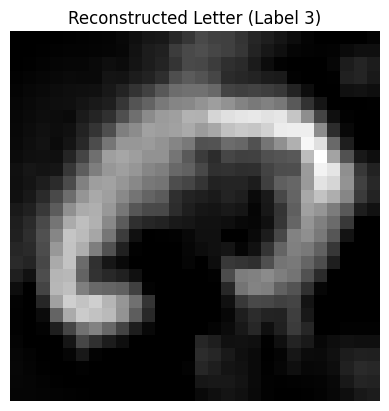


🔍 Prediction Analysis for class 3:
Predicted class: 3
Confidence in target class (3): 0.9997

📊 Similarity Metrics for class 3:
MSE (pixel-wise): 0.0769
SSIM (structural): 0.3024


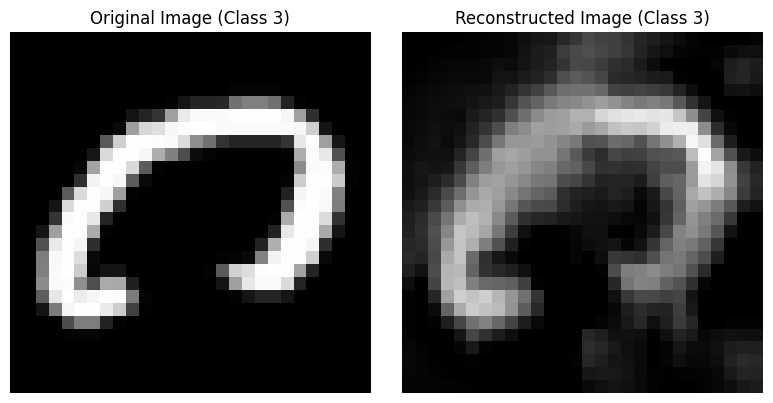


Performing inversion attack for class 4...
Step 0 | Total Loss: 6.3558 | CE: 6.2725 | L2: 0.0057 | Perceptual: 0.0438 | TV: 0.0338
Step 100 | Total Loss: 0.0563 | CE: 0.0010 | L2: 0.0050 | Perceptual: 0.0441 | TV: 0.0062
Step 200 | Total Loss: 0.0549 | CE: 0.0006 | L2: 0.0047 | Perceptual: 0.0441 | TV: 0.0054
Step 300 | Total Loss: 0.0540 | CE: 0.0005 | L2: 0.0045 | Perceptual: 0.0442 | TV: 0.0049
Step 400 | Total Loss: 0.0534 | CE: 0.0004 | L2: 0.0042 | Perceptual: 0.0442 | TV: 0.0046
Step 500 | Total Loss: 0.0531 | CE: 0.0004 | L2: 0.0039 | Perceptual: 0.0443 | TV: 0.0044
Step 600 | Total Loss: 0.0525 | CE: 0.0003 | L2: 0.0037 | Perceptual: 0.0442 | TV: 0.0043
Step 700 | Total Loss: 0.0519 | CE: 0.0003 | L2: 0.0035 | Perceptual: 0.0440 | TV: 0.0041
Step 800 | Total Loss: 0.0515 | CE: 0.0004 | L2: 0.0033 | Perceptual: 0.0439 | TV: 0.0039
Step 900 | Total Loss: 0.0517 | CE: 0.0005 | L2: 0.0031 | Perceptual: 0.0442 | TV: 0.0038
Step 1000 | Total Loss: 0.0516 | CE: 0.0005 | L2: 0.0030 |

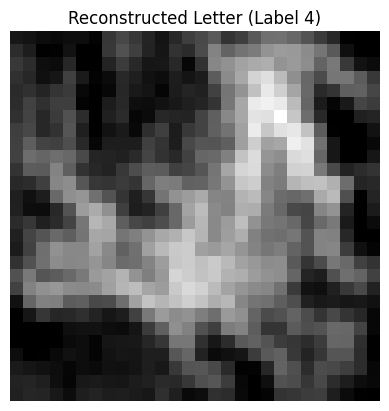


🔍 Prediction Analysis for class 4:
Predicted class: 4
Confidence in target class (4): 0.9991

📊 Similarity Metrics for class 4:
MSE (pixel-wise): 0.1312
SSIM (structural): 0.0676


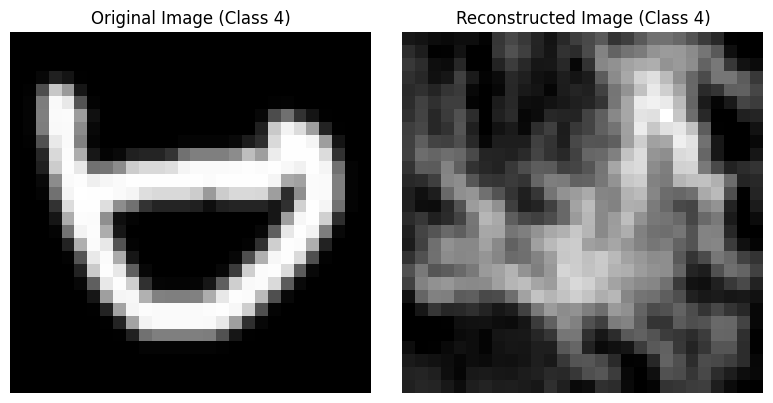


Performing inversion attack for class 5...
Step 0 | Total Loss: 0.2397 | CE: 0.1323 | L2: 0.0094 | Perceptual: 0.0619 | TV: 0.0361
Step 100 | Total Loss: 0.0718 | CE: 0.0005 | L2: 0.0081 | Perceptual: 0.0566 | TV: 0.0067
Step 200 | Total Loss: 0.0679 | CE: 0.0003 | L2: 0.0075 | Perceptual: 0.0541 | TV: 0.0059
Step 300 | Total Loss: 0.0637 | CE: 0.0002 | L2: 0.0070 | Perceptual: 0.0504 | TV: 0.0061
Step 400 | Total Loss: 0.0599 | CE: 0.0002 | L2: 0.0066 | Perceptual: 0.0467 | TV: 0.0064
Step 500 | Total Loss: 0.0565 | CE: 0.0002 | L2: 0.0061 | Perceptual: 0.0434 | TV: 0.0068
Step 600 | Total Loss: 0.0526 | CE: 0.0002 | L2: 0.0056 | Perceptual: 0.0395 | TV: 0.0073
Step 700 | Total Loss: 0.0498 | CE: 0.0002 | L2: 0.0052 | Perceptual: 0.0373 | TV: 0.0071
Step 800 | Total Loss: 0.0473 | CE: 0.0002 | L2: 0.0047 | Perceptual: 0.0352 | TV: 0.0072
Step 900 | Total Loss: 0.0463 | CE: 0.0002 | L2: 0.0043 | Perceptual: 0.0351 | TV: 0.0066
Step 1000 | Total Loss: 0.0444 | CE: 0.0002 | L2: 0.0040 |

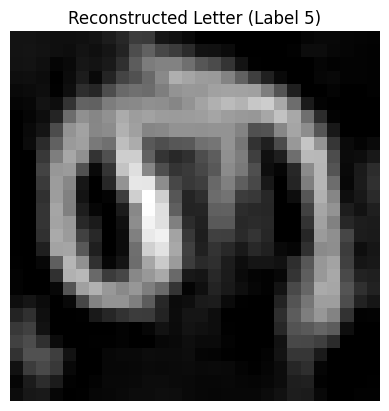


🔍 Prediction Analysis for class 5:
Predicted class: 5
Confidence in target class (5): 0.9998

📊 Similarity Metrics for class 5:
MSE (pixel-wise): 0.0718
SSIM (structural): 0.3381


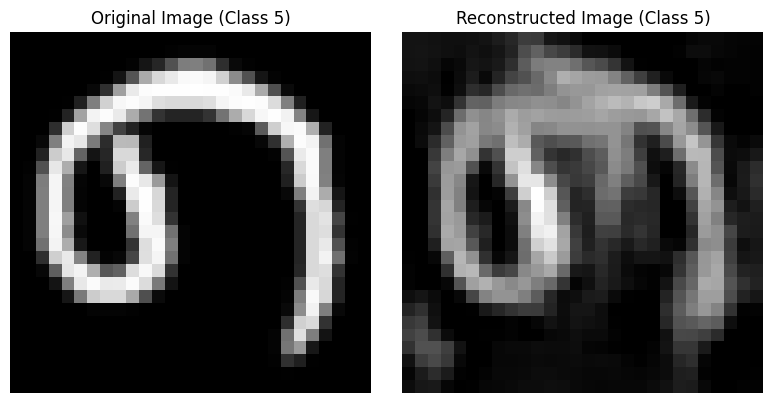


Performing inversion attack for class 6...
Step 0 | Total Loss: 0.2020 | CE: 0.1229 | L2: 0.0048 | Perceptual: 0.0394 | TV: 0.0348
Step 100 | Total Loss: 0.0437 | CE: 0.0004 | L2: 0.0039 | Perceptual: 0.0354 | TV: 0.0040
Step 200 | Total Loss: 0.0412 | CE: 0.0002 | L2: 0.0035 | Perceptual: 0.0337 | TV: 0.0037
Step 300 | Total Loss: 0.0399 | CE: 0.0002 | L2: 0.0032 | Perceptual: 0.0330 | TV: 0.0035
Step 400 | Total Loss: 0.0390 | CE: 0.0002 | L2: 0.0030 | Perceptual: 0.0324 | TV: 0.0034
Step 500 | Total Loss: 0.0383 | CE: 0.0002 | L2: 0.0027 | Perceptual: 0.0321 | TV: 0.0033
Step 600 | Total Loss: 0.0375 | CE: 0.0003 | L2: 0.0025 | Perceptual: 0.0315 | TV: 0.0032
Step 700 | Total Loss: 0.0361 | CE: 0.0003 | L2: 0.0024 | Perceptual: 0.0302 | TV: 0.0032
Step 800 | Total Loss: 0.0352 | CE: 0.0003 | L2: 0.0022 | Perceptual: 0.0295 | TV: 0.0032
Step 900 | Total Loss: 0.0351 | CE: 0.0002 | L2: 0.0021 | Perceptual: 0.0298 | TV: 0.0030
Step 1000 | Total Loss: 0.0349 | CE: 0.0002 | L2: 0.0019 |

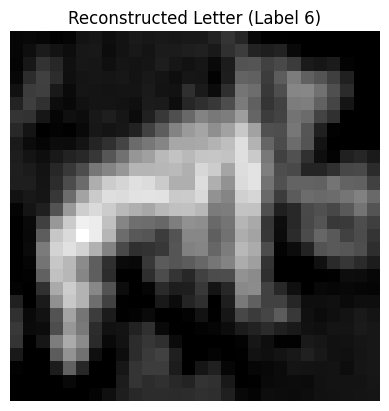


🔍 Prediction Analysis for class 6:
Predicted class: 6
Confidence in target class (6): 0.9996

📊 Similarity Metrics for class 6:
MSE (pixel-wise): 0.0936
SSIM (structural): 0.1750


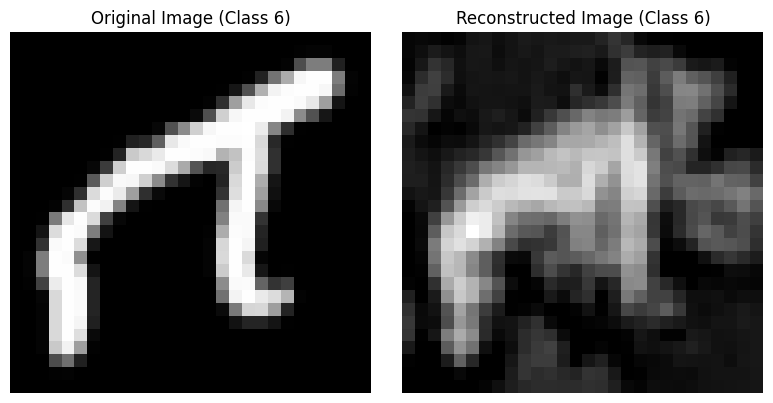


Performing inversion attack for class 7...
Step 0 | Total Loss: 5.2503 | CE: 5.1680 | L2: 0.0061 | Perceptual: 0.0389 | TV: 0.0373
Step 100 | Total Loss: 0.0490 | CE: 0.0006 | L2: 0.0053 | Perceptual: 0.0369 | TV: 0.0062
Step 200 | Total Loss: 0.0478 | CE: 0.0005 | L2: 0.0051 | Perceptual: 0.0372 | TV: 0.0050
Step 300 | Total Loss: 0.0475 | CE: 0.0006 | L2: 0.0049 | Perceptual: 0.0376 | TV: 0.0044
Step 400 | Total Loss: 0.0472 | CE: 0.0006 | L2: 0.0047 | Perceptual: 0.0378 | TV: 0.0041
Step 500 | Total Loss: 0.0470 | CE: 0.0006 | L2: 0.0045 | Perceptual: 0.0379 | TV: 0.0039
Step 600 | Total Loss: 0.0468 | CE: 0.0006 | L2: 0.0044 | Perceptual: 0.0380 | TV: 0.0038
Step 700 | Total Loss: 0.0466 | CE: 0.0006 | L2: 0.0042 | Perceptual: 0.0381 | TV: 0.0037
Step 800 | Total Loss: 0.0464 | CE: 0.0005 | L2: 0.0040 | Perceptual: 0.0381 | TV: 0.0037
Step 900 | Total Loss: 0.0464 | CE: 0.0005 | L2: 0.0039 | Perceptual: 0.0383 | TV: 0.0037
Step 1000 | Total Loss: 0.0462 | CE: 0.0005 | L2: 0.0038 |

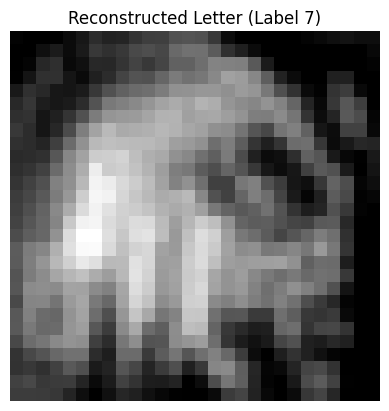


🔍 Prediction Analysis for class 7:
Predicted class: 7
Confidence in target class (7): 0.9991

📊 Similarity Metrics for class 7:
MSE (pixel-wise): 0.1560
SSIM (structural): 0.1236


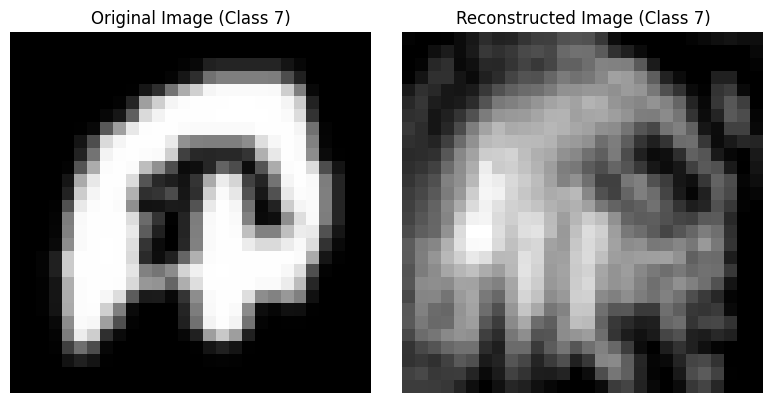


Performing inversion attack for class 8...
Step 0 | Total Loss: 1.5921 | CE: 1.5275 | L2: 0.0050 | Perceptual: 0.0294 | TV: 0.0301
Step 100 | Total Loss: 0.0361 | CE: 0.0007 | L2: 0.0043 | Perceptual: 0.0273 | TV: 0.0039
Step 200 | Total Loss: 0.0348 | CE: 0.0004 | L2: 0.0040 | Perceptual: 0.0268 | TV: 0.0036
Step 300 | Total Loss: 0.0337 | CE: 0.0003 | L2: 0.0038 | Perceptual: 0.0262 | TV: 0.0034
Step 400 | Total Loss: 0.0325 | CE: 0.0003 | L2: 0.0036 | Perceptual: 0.0253 | TV: 0.0033
Step 500 | Total Loss: 0.0316 | CE: 0.0003 | L2: 0.0034 | Perceptual: 0.0246 | TV: 0.0032
Step 600 | Total Loss: 0.0309 | CE: 0.0003 | L2: 0.0032 | Perceptual: 0.0243 | TV: 0.0031
Step 700 | Total Loss: 0.0301 | CE: 0.0003 | L2: 0.0030 | Perceptual: 0.0236 | TV: 0.0032
Step 800 | Total Loss: 0.0291 | CE: 0.0003 | L2: 0.0028 | Perceptual: 0.0229 | TV: 0.0032
Step 900 | Total Loss: 0.0291 | CE: 0.0003 | L2: 0.0026 | Perceptual: 0.0232 | TV: 0.0030
Step 1000 | Total Loss: 0.0287 | CE: 0.0003 | L2: 0.0025 |

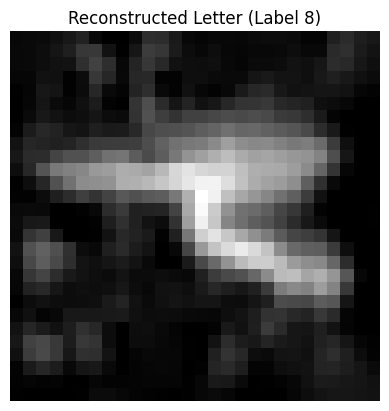


🔍 Prediction Analysis for class 8:
Predicted class: 8
Confidence in target class (8): 0.9997

📊 Similarity Metrics for class 8:
MSE (pixel-wise): 0.0537
SSIM (structural): 0.2565


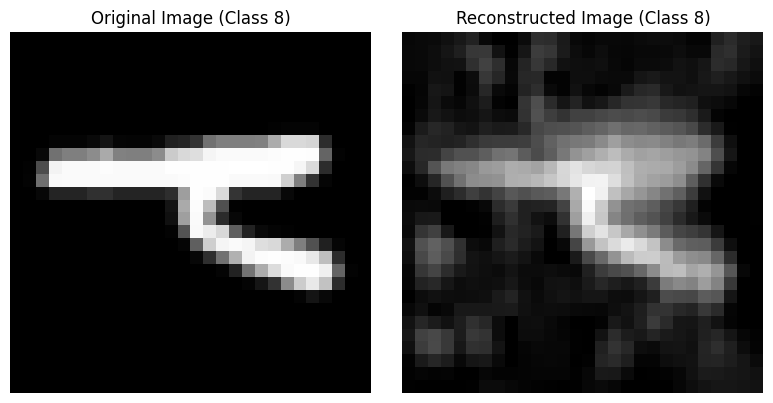


Performing inversion attack for class 9...
Step 0 | Total Loss: 2.5244 | CE: 2.4740 | L2: 0.0048 | Perceptual: 0.0112 | TV: 0.0344
Step 100 | Total Loss: 0.0216 | CE: 0.0021 | L2: 0.0039 | Perceptual: 0.0098 | TV: 0.0058
Step 200 | Total Loss: 0.0200 | CE: 0.0016 | L2: 0.0035 | Perceptual: 0.0099 | TV: 0.0050
Step 300 | Total Loss: 0.0194 | CE: 0.0021 | L2: 0.0031 | Perceptual: 0.0097 | TV: 0.0044
Step 400 | Total Loss: 0.0185 | CE: 0.0021 | L2: 0.0028 | Perceptual: 0.0095 | TV: 0.0042
Step 500 | Total Loss: 0.0169 | CE: 0.0014 | L2: 0.0024 | Perceptual: 0.0095 | TV: 0.0037
Step 600 | Total Loss: 0.0160 | CE: 0.0013 | L2: 0.0021 | Perceptual: 0.0093 | TV: 0.0033
Step 700 | Total Loss: 0.0150 | CE: 0.0012 | L2: 0.0018 | Perceptual: 0.0089 | TV: 0.0031
Step 800 | Total Loss: 0.0141 | CE: 0.0011 | L2: 0.0016 | Perceptual: 0.0086 | TV: 0.0028
Step 900 | Total Loss: 0.0137 | CE: 0.0011 | L2: 0.0014 | Perceptual: 0.0086 | TV: 0.0026
Step 1000 | Total Loss: 0.0134 | CE: 0.0011 | L2: 0.0012 |

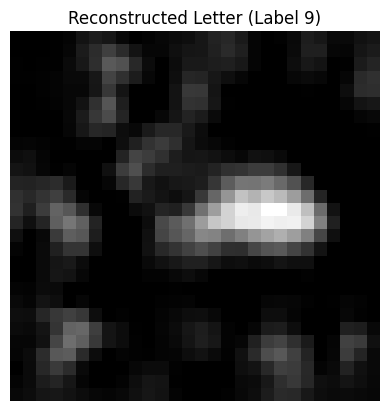


🔍 Prediction Analysis for class 9:
Predicted class: 9
Confidence in target class (9): 0.9993

📊 Similarity Metrics for class 9:
MSE (pixel-wise): 0.0371
SSIM (structural): 0.2364


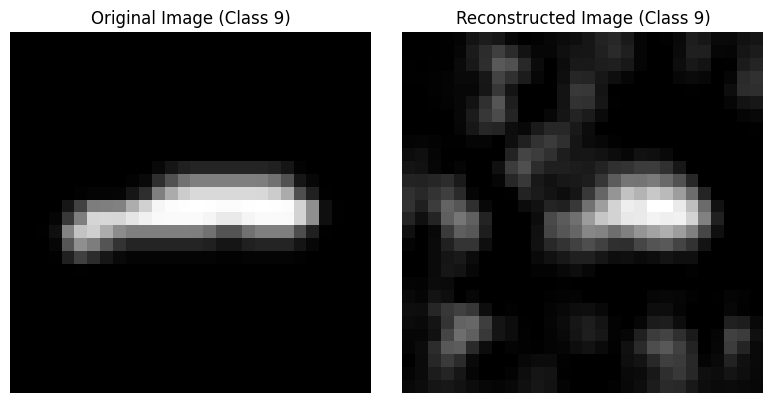


Performing inversion attack for class 10...
Step 0 | Total Loss: 2.0686 | CE: 1.9710 | L2: 0.0038 | Perceptual: 0.0632 | TV: 0.0307
Step 100 | Total Loss: 0.0638 | CE: 0.0005 | L2: 0.0030 | Perceptual: 0.0572 | TV: 0.0032
Step 200 | Total Loss: 0.0567 | CE: 0.0002 | L2: 0.0027 | Perceptual: 0.0505 | TV: 0.0033
Step 300 | Total Loss: 0.0481 | CE: 0.0001 | L2: 0.0025 | Perceptual: 0.0417 | TV: 0.0038
Step 400 | Total Loss: 0.0427 | CE: 0.0001 | L2: 0.0023 | Perceptual: 0.0361 | TV: 0.0042
Step 500 | Total Loss: 0.0402 | CE: 0.0001 | L2: 0.0022 | Perceptual: 0.0335 | TV: 0.0045
Step 600 | Total Loss: 0.0386 | CE: 0.0001 | L2: 0.0020 | Perceptual: 0.0318 | TV: 0.0048
Step 700 | Total Loss: 0.0374 | CE: 0.0001 | L2: 0.0019 | Perceptual: 0.0305 | TV: 0.0050
Step 800 | Total Loss: 0.0365 | CE: 0.0001 | L2: 0.0017 | Perceptual: 0.0294 | TV: 0.0053
Step 900 | Total Loss: 0.0368 | CE: 0.0001 | L2: 0.0016 | Perceptual: 0.0304 | TV: 0.0047
Step 1000 | Total Loss: 0.0364 | CE: 0.0001 | L2: 0.0015 

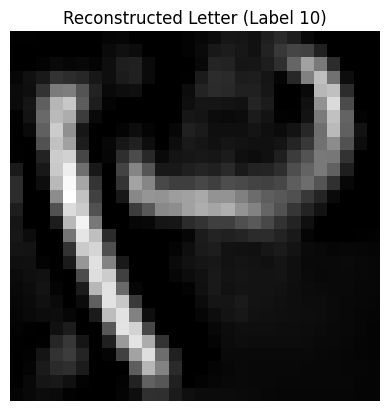


🔍 Prediction Analysis for class 10:
Predicted class: 10
Confidence in target class (10): 0.9999

📊 Similarity Metrics for class 10:
MSE (pixel-wise): 0.0618
SSIM (structural): 0.2806


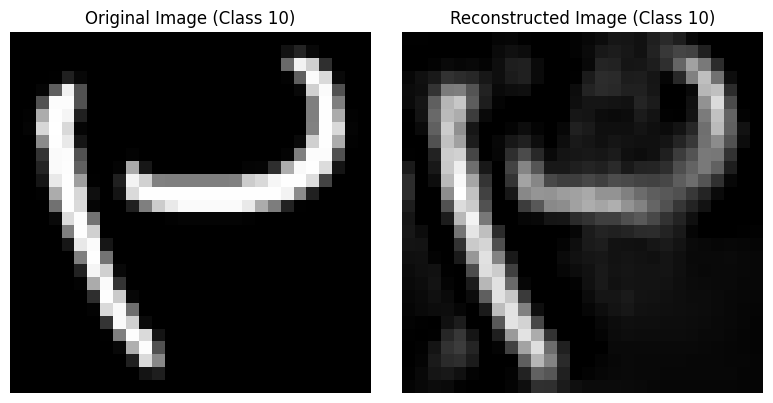


Performing inversion attack for class 11...
Step 0 | Total Loss: 0.3738 | CE: 0.2920 | L2: 0.0059 | Perceptual: 0.0432 | TV: 0.0326
Step 100 | Total Loss: 0.0494 | CE: 0.0004 | L2: 0.0051 | Perceptual: 0.0394 | TV: 0.0045
Step 200 | Total Loss: 0.0475 | CE: 0.0002 | L2: 0.0048 | Perceptual: 0.0387 | TV: 0.0038
Step 300 | Total Loss: 0.0458 | CE: 0.0001 | L2: 0.0045 | Perceptual: 0.0377 | TV: 0.0035
Step 400 | Total Loss: 0.0440 | CE: 0.0001 | L2: 0.0042 | Perceptual: 0.0364 | TV: 0.0032
Step 500 | Total Loss: 0.0427 | CE: 0.0001 | L2: 0.0039 | Perceptual: 0.0356 | TV: 0.0031
Step 600 | Total Loss: 0.0416 | CE: 0.0001 | L2: 0.0036 | Perceptual: 0.0348 | TV: 0.0031
Step 700 | Total Loss: 0.0403 | CE: 0.0001 | L2: 0.0034 | Perceptual: 0.0338 | TV: 0.0030
Step 800 | Total Loss: 0.0393 | CE: 0.0001 | L2: 0.0031 | Perceptual: 0.0331 | TV: 0.0030
Step 900 | Total Loss: 0.0391 | CE: 0.0002 | L2: 0.0029 | Perceptual: 0.0333 | TV: 0.0028
Step 1000 | Total Loss: 0.0386 | CE: 0.0001 | L2: 0.0027 

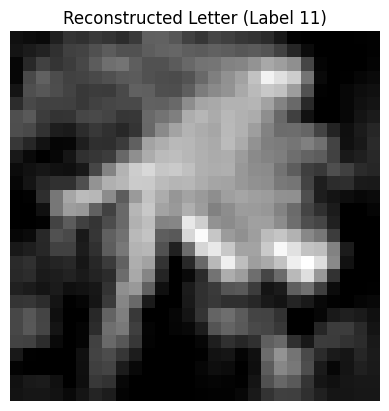


🔍 Prediction Analysis for class 11:
Predicted class: 11
Confidence in target class (11): 0.9998

📊 Similarity Metrics for class 11:
MSE (pixel-wise): 0.0607
SSIM (structural): 0.1895


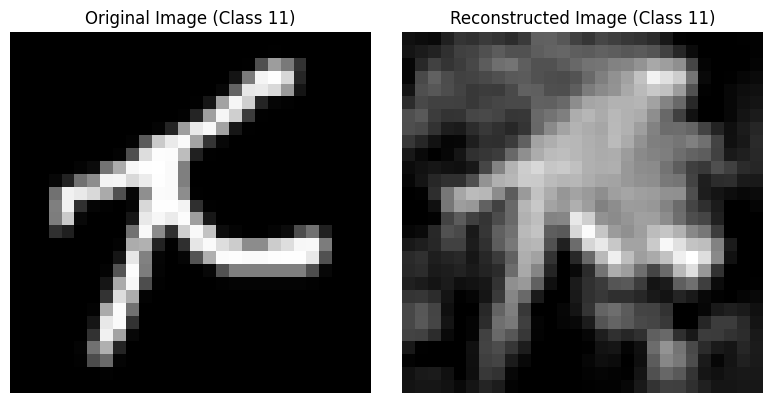


Performing inversion attack for class 12...
Step 0 | Total Loss: 9.8590 | CE: 9.8037 | L2: 0.0036 | Perceptual: 0.0176 | TV: 0.0342
Step 100 | Total Loss: 0.0293 | CE: 0.0061 | L2: 0.0028 | Perceptual: 0.0158 | TV: 0.0046
Step 200 | Total Loss: 0.0258 | CE: 0.0040 | L2: 0.0025 | Perceptual: 0.0152 | TV: 0.0041
Step 300 | Total Loss: 0.0243 | CE: 0.0033 | L2: 0.0023 | Perceptual: 0.0150 | TV: 0.0037
Step 400 | Total Loss: 0.0233 | CE: 0.0028 | L2: 0.0021 | Perceptual: 0.0149 | TV: 0.0035
Step 500 | Total Loss: 0.0225 | CE: 0.0025 | L2: 0.0019 | Perceptual: 0.0148 | TV: 0.0033
Step 600 | Total Loss: 0.0204 | CE: 0.0014 | L2: 0.0017 | Perceptual: 0.0145 | TV: 0.0028
Step 700 | Total Loss: 0.0195 | CE: 0.0011 | L2: 0.0015 | Perceptual: 0.0143 | TV: 0.0026
Step 800 | Total Loss: 0.0187 | CE: 0.0009 | L2: 0.0013 | Perceptual: 0.0141 | TV: 0.0023
Step 900 | Total Loss: 0.0181 | CE: 0.0010 | L2: 0.0012 | Perceptual: 0.0139 | TV: 0.0021
Step 1000 | Total Loss: 0.0177 | CE: 0.0009 | L2: 0.0011 

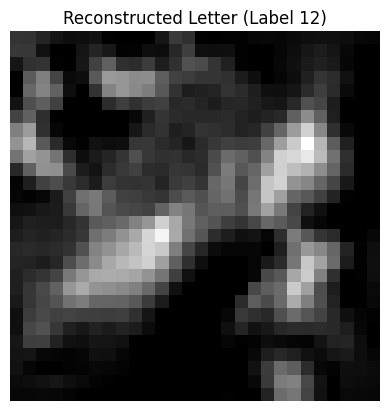


🔍 Prediction Analysis for class 12:
Predicted class: 12
Confidence in target class (12): 0.9993

📊 Similarity Metrics for class 12:
MSE (pixel-wise): 0.0792
SSIM (structural): 0.1152


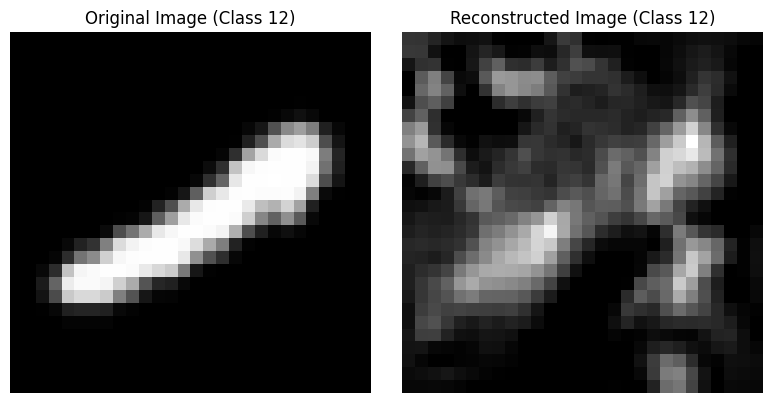


Performing inversion attack for class 13...
Step 0 | Total Loss: 0.0858 | CE: 0.0013 | L2: 0.0071 | Perceptual: 0.0384 | TV: 0.0391
Step 100 | Total Loss: 0.0304 | CE: 0.0001 | L2: 0.0047 | Perceptual: 0.0186 | TV: 0.0070
Step 200 | Total Loss: 0.0255 | CE: 0.0001 | L2: 0.0034 | Perceptual: 0.0136 | TV: 0.0084
Step 300 | Total Loss: 0.0237 | CE: 0.0002 | L2: 0.0027 | Perceptual: 0.0120 | TV: 0.0088
Step 400 | Total Loss: 0.0236 | CE: 0.0002 | L2: 0.0024 | Perceptual: 0.0123 | TV: 0.0086
Step 500 | Total Loss: 0.0237 | CE: 0.0003 | L2: 0.0023 | Perceptual: 0.0127 | TV: 0.0085
Step 600 | Total Loss: 0.0239 | CE: 0.0003 | L2: 0.0022 | Perceptual: 0.0132 | TV: 0.0083
Step 700 | Total Loss: 0.0241 | CE: 0.0002 | L2: 0.0022 | Perceptual: 0.0136 | TV: 0.0081
Step 800 | Total Loss: 0.0244 | CE: 0.0002 | L2: 0.0021 | Perceptual: 0.0140 | TV: 0.0080
Step 900 | Total Loss: 0.0251 | CE: 0.0002 | L2: 0.0020 | Perceptual: 0.0156 | TV: 0.0072
Step 1000 | Total Loss: 0.0257 | CE: 0.0002 | L2: 0.0020 

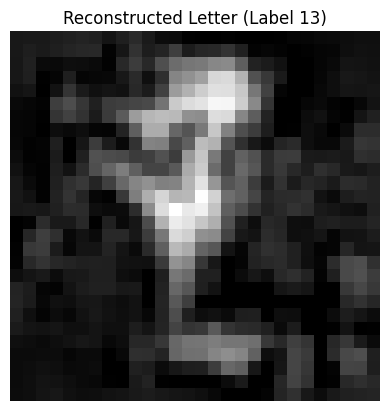


🔍 Prediction Analysis for class 13:
Predicted class: 13
Confidence in target class (13): 0.9997

📊 Similarity Metrics for class 13:
MSE (pixel-wise): 0.0568
SSIM (structural): 0.2045


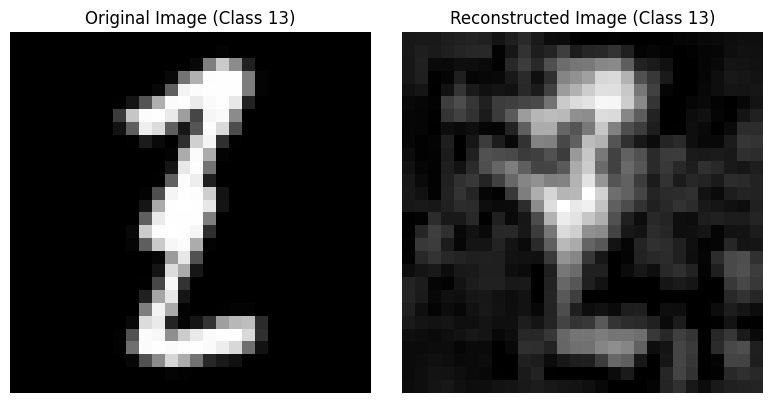


Performing inversion attack for class 14...
Step 0 | Total Loss: 0.9899 | CE: 0.9039 | L2: 0.0071 | Perceptual: 0.0447 | TV: 0.0342
Step 100 | Total Loss: 0.0531 | CE: 0.0008 | L2: 0.0060 | Perceptual: 0.0412 | TV: 0.0050
Step 200 | Total Loss: 0.0505 | CE: 0.0006 | L2: 0.0056 | Perceptual: 0.0401 | TV: 0.0042
Step 300 | Total Loss: 0.0489 | CE: 0.0006 | L2: 0.0052 | Perceptual: 0.0393 | TV: 0.0038
Step 400 | Total Loss: 0.0477 | CE: 0.0006 | L2: 0.0048 | Perceptual: 0.0389 | TV: 0.0035
Step 500 | Total Loss: 0.0468 | CE: 0.0006 | L2: 0.0045 | Perceptual: 0.0386 | TV: 0.0032
Step 600 | Total Loss: 0.0459 | CE: 0.0006 | L2: 0.0041 | Perceptual: 0.0381 | TV: 0.0030
Step 700 | Total Loss: 0.0442 | CE: 0.0005 | L2: 0.0038 | Perceptual: 0.0370 | TV: 0.0030
Step 800 | Total Loss: 0.0429 | CE: 0.0004 | L2: 0.0035 | Perceptual: 0.0361 | TV: 0.0029
Step 900 | Total Loss: 0.0424 | CE: 0.0004 | L2: 0.0032 | Perceptual: 0.0361 | TV: 0.0027
Step 1000 | Total Loss: 0.0420 | CE: 0.0004 | L2: 0.0030 

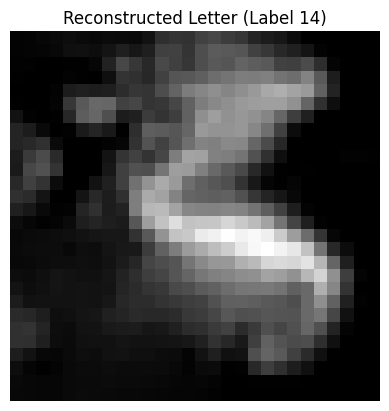


🔍 Prediction Analysis for class 14:
Predicted class: 14
Confidence in target class (14): 0.9996

📊 Similarity Metrics for class 14:
MSE (pixel-wise): 0.0631
SSIM (structural): 0.2609


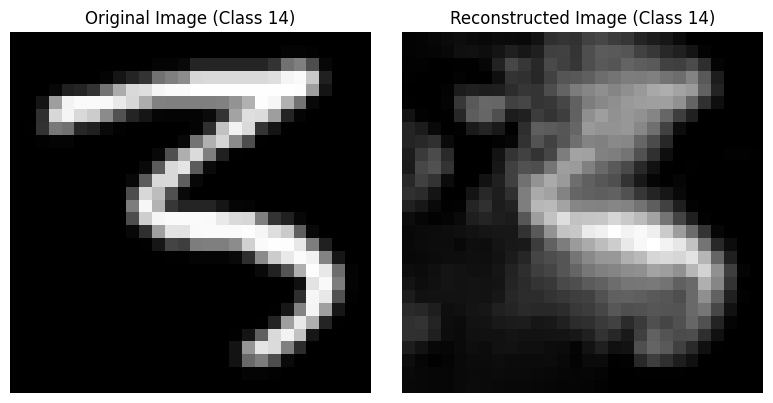


Performing inversion attack for class 15...
Step 0 | Total Loss: 0.4041 | CE: 0.3207 | L2: 0.0105 | Perceptual: 0.0336 | TV: 0.0394
Step 100 | Total Loss: 0.0476 | CE: 0.0009 | L2: 0.0088 | Perceptual: 0.0294 | TV: 0.0086
Step 200 | Total Loss: 0.0441 | CE: 0.0007 | L2: 0.0079 | Perceptual: 0.0282 | TV: 0.0073
Step 300 | Total Loss: 0.0419 | CE: 0.0007 | L2: 0.0073 | Perceptual: 0.0271 | TV: 0.0068
Step 400 | Total Loss: 0.0400 | CE: 0.0006 | L2: 0.0067 | Perceptual: 0.0262 | TV: 0.0064
Step 500 | Total Loss: 0.0383 | CE: 0.0006 | L2: 0.0062 | Perceptual: 0.0251 | TV: 0.0064
Step 600 | Total Loss: 0.0369 | CE: 0.0006 | L2: 0.0058 | Perceptual: 0.0240 | TV: 0.0065
Step 700 | Total Loss: 0.0356 | CE: 0.0007 | L2: 0.0053 | Perceptual: 0.0232 | TV: 0.0064
Step 800 | Total Loss: 0.0346 | CE: 0.0007 | L2: 0.0049 | Perceptual: 0.0227 | TV: 0.0063
Step 900 | Total Loss: 0.0342 | CE: 0.0007 | L2: 0.0046 | Perceptual: 0.0230 | TV: 0.0059
Step 1000 | Total Loss: 0.0337 | CE: 0.0007 | L2: 0.0043 

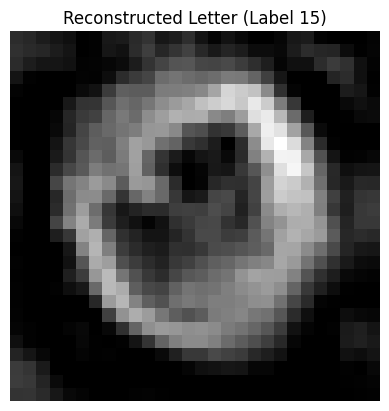


🔍 Prediction Analysis for class 15:
Predicted class: 15
Confidence in target class (15): 0.9992

📊 Similarity Metrics for class 15:
MSE (pixel-wise): 0.0958
SSIM (structural): 0.2872


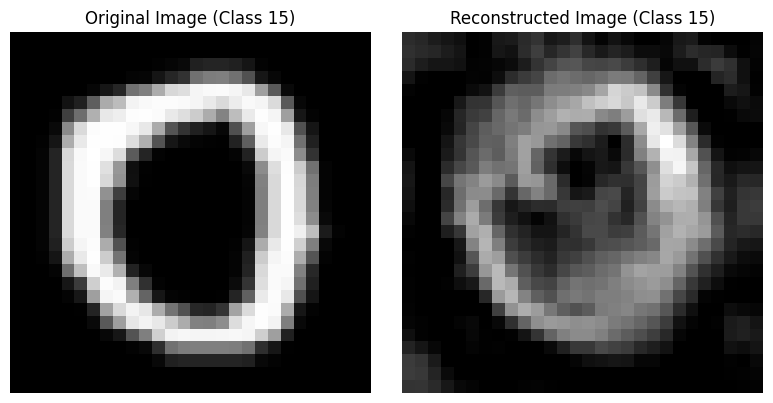


Performing inversion attack for class 16...
Step 0 | Total Loss: 3.9611 | CE: 3.8846 | L2: 0.0061 | Perceptual: 0.0344 | TV: 0.0360
Step 100 | Total Loss: 0.0438 | CE: 0.0010 | L2: 0.0052 | Perceptual: 0.0324 | TV: 0.0052
Step 200 | Total Loss: 0.0418 | CE: 0.0007 | L2: 0.0048 | Perceptual: 0.0316 | TV: 0.0046
Step 300 | Total Loss: 0.0406 | CE: 0.0005 | L2: 0.0045 | Perceptual: 0.0312 | TV: 0.0043
Step 400 | Total Loss: 0.0397 | CE: 0.0003 | L2: 0.0042 | Perceptual: 0.0311 | TV: 0.0041
Step 500 | Total Loss: 0.0390 | CE: 0.0003 | L2: 0.0040 | Perceptual: 0.0310 | TV: 0.0038
Step 600 | Total Loss: 0.0383 | CE: 0.0002 | L2: 0.0037 | Perceptual: 0.0309 | TV: 0.0035
Step 700 | Total Loss: 0.0377 | CE: 0.0002 | L2: 0.0034 | Perceptual: 0.0309 | TV: 0.0032
Step 800 | Total Loss: 0.0372 | CE: 0.0002 | L2: 0.0031 | Perceptual: 0.0308 | TV: 0.0030
Step 900 | Total Loss: 0.0374 | CE: 0.0003 | L2: 0.0029 | Perceptual: 0.0314 | TV: 0.0028
Step 1000 | Total Loss: 0.0372 | CE: 0.0004 | L2: 0.0026 

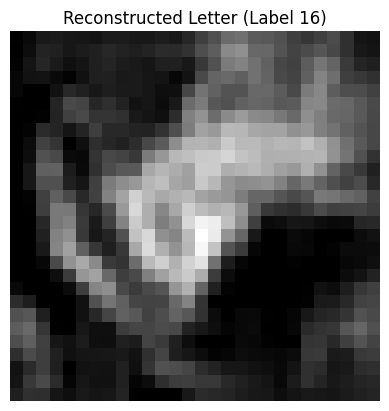


🔍 Prediction Analysis for class 16:
Predicted class: 16
Confidence in target class (16): 0.9994

📊 Similarity Metrics for class 16:
MSE (pixel-wise): 0.0768
SSIM (structural): 0.1343


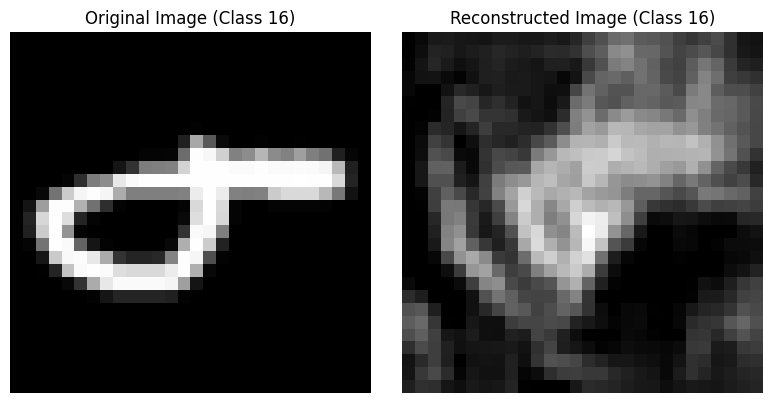


Performing inversion attack for class 17...
Step 0 | Total Loss: 1.5311 | CE: 1.4595 | L2: 0.0066 | Perceptual: 0.0324 | TV: 0.0326
Step 100 | Total Loss: 0.0492 | CE: 0.0024 | L2: 0.0060 | Perceptual: 0.0327 | TV: 0.0081
Step 200 | Total Loss: 0.0459 | CE: 0.0014 | L2: 0.0057 | Perceptual: 0.0323 | TV: 0.0064
Step 300 | Total Loss: 0.0441 | CE: 0.0007 | L2: 0.0055 | Perceptual: 0.0320 | TV: 0.0059
Step 400 | Total Loss: 0.0437 | CE: 0.0006 | L2: 0.0052 | Perceptual: 0.0323 | TV: 0.0056
Step 500 | Total Loss: 0.0434 | CE: 0.0005 | L2: 0.0050 | Perceptual: 0.0323 | TV: 0.0055
Step 600 | Total Loss: 0.0432 | CE: 0.0004 | L2: 0.0049 | Perceptual: 0.0323 | TV: 0.0056
Step 700 | Total Loss: 0.0427 | CE: 0.0003 | L2: 0.0047 | Perceptual: 0.0319 | TV: 0.0057
Step 800 | Total Loss: 0.0425 | CE: 0.0003 | L2: 0.0046 | Perceptual: 0.0316 | TV: 0.0060
Step 900 | Total Loss: 0.0431 | CE: 0.0005 | L2: 0.0045 | Perceptual: 0.0318 | TV: 0.0063
Step 1000 | Total Loss: 0.0431 | CE: 0.0006 | L2: 0.0044 

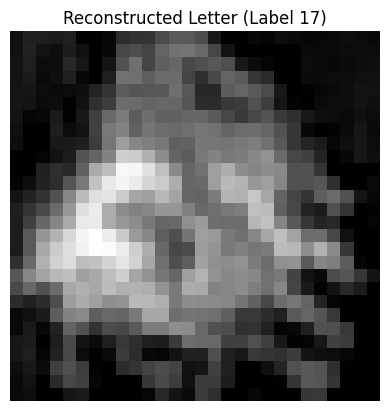


🔍 Prediction Analysis for class 17:
Predicted class: 17
Confidence in target class (17): 0.9985

📊 Similarity Metrics for class 17:
MSE (pixel-wise): 0.0726
SSIM (structural): 0.1467


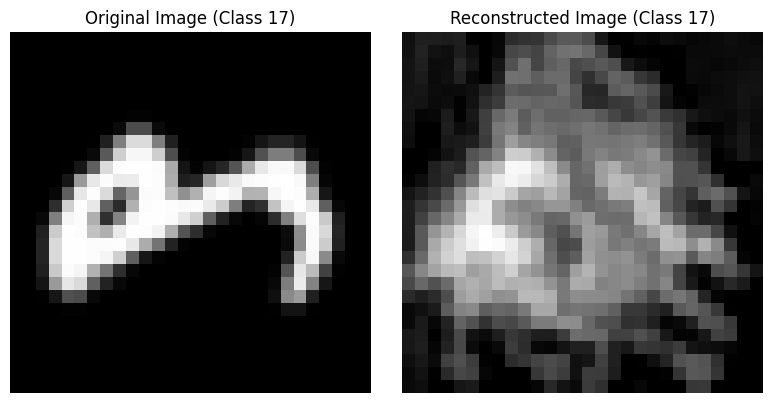


Performing inversion attack for class 18...
Step 0 | Total Loss: 1.1448 | CE: 1.0773 | L2: 0.0070 | Perceptual: 0.0252 | TV: 0.0354
Step 100 | Total Loss: 0.0337 | CE: 0.0008 | L2: 0.0060 | Perceptual: 0.0222 | TV: 0.0047
Step 200 | Total Loss: 0.0317 | CE: 0.0006 | L2: 0.0056 | Perceptual: 0.0214 | TV: 0.0041
Step 300 | Total Loss: 0.0305 | CE: 0.0005 | L2: 0.0052 | Perceptual: 0.0209 | TV: 0.0038
Step 400 | Total Loss: 0.0297 | CE: 0.0005 | L2: 0.0049 | Perceptual: 0.0207 | TV: 0.0037
Step 500 | Total Loss: 0.0289 | CE: 0.0004 | L2: 0.0046 | Perceptual: 0.0203 | TV: 0.0036
Step 600 | Total Loss: 0.0283 | CE: 0.0004 | L2: 0.0043 | Perceptual: 0.0201 | TV: 0.0035
Step 700 | Total Loss: 0.0277 | CE: 0.0004 | L2: 0.0040 | Perceptual: 0.0199 | TV: 0.0034
Step 800 | Total Loss: 0.0272 | CE: 0.0004 | L2: 0.0037 | Perceptual: 0.0197 | TV: 0.0033
Step 900 | Total Loss: 0.0272 | CE: 0.0005 | L2: 0.0035 | Perceptual: 0.0201 | TV: 0.0031
Step 1000 | Total Loss: 0.0267 | CE: 0.0006 | L2: 0.0032 

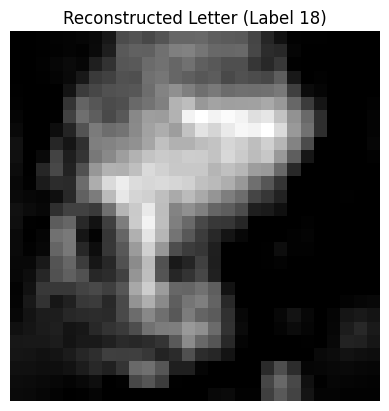


🔍 Prediction Analysis for class 18:
Predicted class: 18
Confidence in target class (18): 0.9996

📊 Similarity Metrics for class 18:
MSE (pixel-wise): 0.1048
SSIM (structural): 0.1880


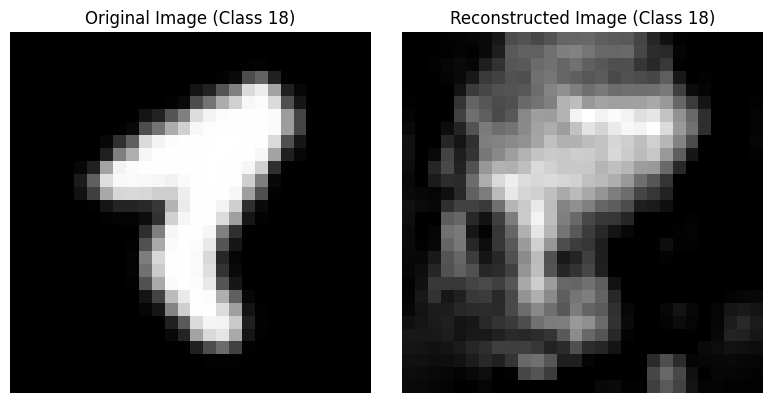


Performing inversion attack for class 19...
Step 0 | Total Loss: 1.2861 | CE: 1.2165 | L2: 0.0077 | Perceptual: 0.0229 | TV: 0.0390
Step 100 | Total Loss: 0.0319 | CE: 0.0009 | L2: 0.0065 | Perceptual: 0.0181 | TV: 0.0064
Step 200 | Total Loss: 0.0299 | CE: 0.0006 | L2: 0.0060 | Perceptual: 0.0178 | TV: 0.0055
Step 300 | Total Loss: 0.0285 | CE: 0.0006 | L2: 0.0056 | Perceptual: 0.0172 | TV: 0.0051
Step 400 | Total Loss: 0.0274 | CE: 0.0004 | L2: 0.0052 | Perceptual: 0.0169 | TV: 0.0049
Step 500 | Total Loss: 0.0261 | CE: 0.0003 | L2: 0.0049 | Perceptual: 0.0161 | TV: 0.0048
Step 600 | Total Loss: 0.0248 | CE: 0.0004 | L2: 0.0047 | Perceptual: 0.0151 | TV: 0.0047
Step 700 | Total Loss: 0.0238 | CE: 0.0003 | L2: 0.0044 | Perceptual: 0.0145 | TV: 0.0046
Step 800 | Total Loss: 0.0232 | CE: 0.0003 | L2: 0.0042 | Perceptual: 0.0142 | TV: 0.0045
Step 900 | Total Loss: 0.0231 | CE: 0.0003 | L2: 0.0040 | Perceptual: 0.0145 | TV: 0.0043
Step 1000 | Total Loss: 0.0228 | CE: 0.0003 | L2: 0.0038 

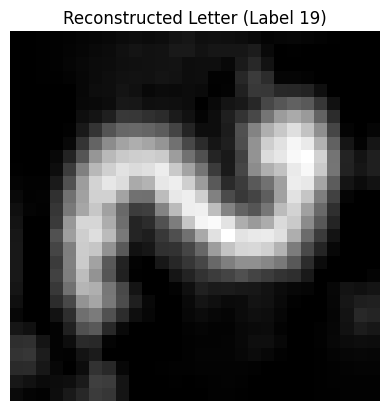


🔍 Prediction Analysis for class 19:
Predicted class: 19
Confidence in target class (19): 0.9996

📊 Similarity Metrics for class 19:
MSE (pixel-wise): 0.0540
SSIM (structural): 0.4853


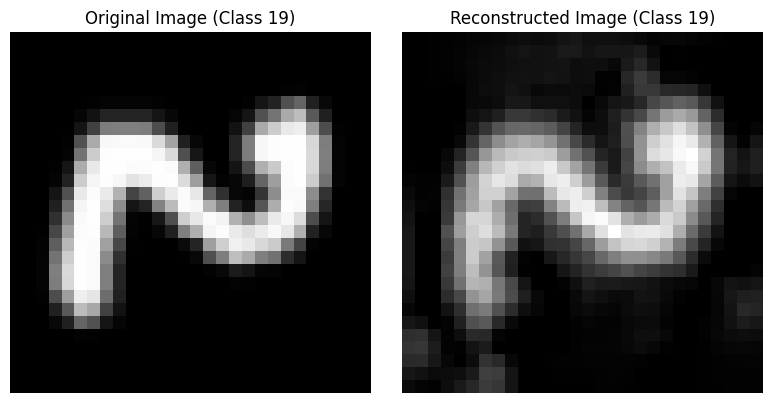


Performing inversion attack for class 20...
Step 0 | Total Loss: 6.3210 | CE: 6.2403 | L2: 0.0042 | Perceptual: 0.0443 | TV: 0.0322
Step 100 | Total Loss: 0.0522 | CE: 0.0012 | L2: 0.0034 | Perceptual: 0.0437 | TV: 0.0038
Step 200 | Total Loss: 0.0499 | CE: 0.0008 | L2: 0.0032 | Perceptual: 0.0430 | TV: 0.0029
Step 300 | Total Loss: 0.0487 | CE: 0.0006 | L2: 0.0029 | Perceptual: 0.0425 | TV: 0.0027
Step 400 | Total Loss: 0.0479 | CE: 0.0006 | L2: 0.0027 | Perceptual: 0.0422 | TV: 0.0025
Step 500 | Total Loss: 0.0470 | CE: 0.0005 | L2: 0.0025 | Perceptual: 0.0417 | TV: 0.0023
Step 600 | Total Loss: 0.0463 | CE: 0.0004 | L2: 0.0023 | Perceptual: 0.0414 | TV: 0.0022
Step 700 | Total Loss: 0.0456 | CE: 0.0004 | L2: 0.0021 | Perceptual: 0.0410 | TV: 0.0021
Step 800 | Total Loss: 0.0450 | CE: 0.0004 | L2: 0.0019 | Perceptual: 0.0407 | TV: 0.0020
Step 900 | Total Loss: 0.0449 | CE: 0.0004 | L2: 0.0018 | Perceptual: 0.0408 | TV: 0.0019
Step 1000 | Total Loss: 0.0443 | CE: 0.0003 | L2: 0.0017 

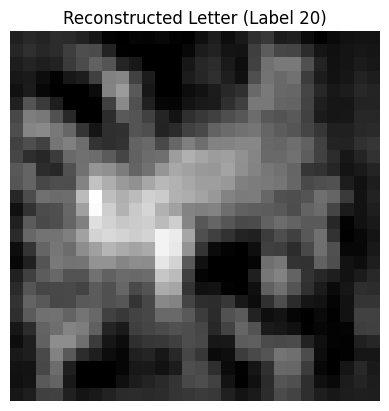


🔍 Prediction Analysis for class 20:
Predicted class: 20
Confidence in target class (20): 0.9997

📊 Similarity Metrics for class 20:
MSE (pixel-wise): 0.0523
SSIM (structural): 0.0653


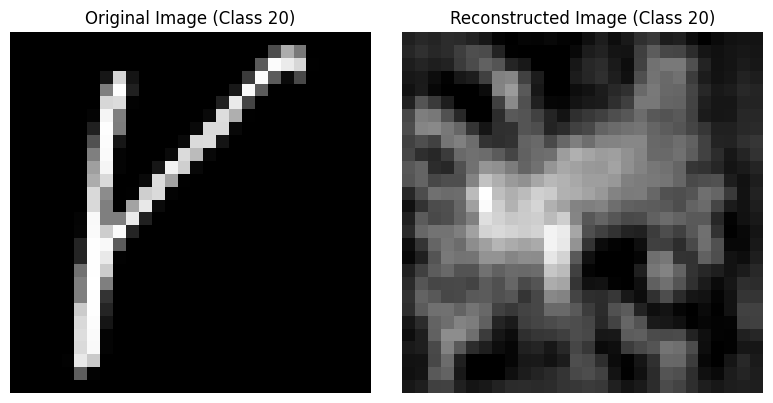


Performing inversion attack for class 21...
Step 0 | Total Loss: 0.1419 | CE: 0.0716 | L2: 0.0068 | Perceptual: 0.0270 | TV: 0.0365
Step 100 | Total Loss: 0.0338 | CE: 0.0004 | L2: 0.0056 | Perceptual: 0.0221 | TV: 0.0056
Step 200 | Total Loss: 0.0302 | CE: 0.0004 | L2: 0.0050 | Perceptual: 0.0196 | TV: 0.0051
Step 300 | Total Loss: 0.0274 | CE: 0.0004 | L2: 0.0045 | Perceptual: 0.0177 | TV: 0.0048
Step 400 | Total Loss: 0.0254 | CE: 0.0005 | L2: 0.0040 | Perceptual: 0.0164 | TV: 0.0045
Step 500 | Total Loss: 0.0238 | CE: 0.0005 | L2: 0.0035 | Perceptual: 0.0154 | TV: 0.0044
Step 600 | Total Loss: 0.0225 | CE: 0.0005 | L2: 0.0032 | Perceptual: 0.0144 | TV: 0.0044
Step 700 | Total Loss: 0.0216 | CE: 0.0005 | L2: 0.0030 | Perceptual: 0.0137 | TV: 0.0044
Step 800 | Total Loss: 0.0209 | CE: 0.0004 | L2: 0.0029 | Perceptual: 0.0132 | TV: 0.0044
Step 900 | Total Loss: 0.0210 | CE: 0.0003 | L2: 0.0028 | Perceptual: 0.0137 | TV: 0.0042
Step 1000 | Total Loss: 0.0209 | CE: 0.0003 | L2: 0.0027 

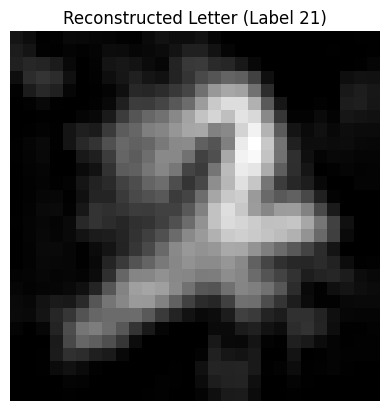


🔍 Prediction Analysis for class 21:
Predicted class: 21
Confidence in target class (21): 0.9997

📊 Similarity Metrics for class 21:
MSE (pixel-wise): 0.0500
SSIM (structural): 0.3871


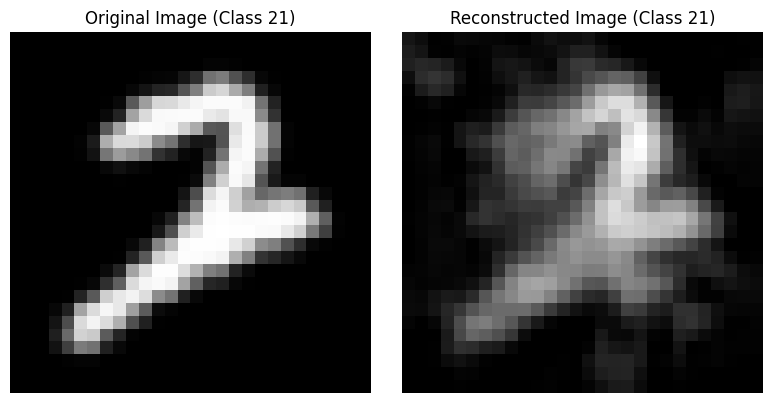


Performing inversion attack for class 22...
Step 0 | Total Loss: 6.3517 | CE: 6.2734 | L2: 0.0067 | Perceptual: 0.0360 | TV: 0.0356
Step 100 | Total Loss: 0.0468 | CE: 0.0017 | L2: 0.0058 | Perceptual: 0.0331 | TV: 0.0062
Step 200 | Total Loss: 0.0441 | CE: 0.0012 | L2: 0.0054 | Perceptual: 0.0323 | TV: 0.0052
Step 300 | Total Loss: 0.0421 | CE: 0.0008 | L2: 0.0050 | Perceptual: 0.0316 | TV: 0.0046
Step 400 | Total Loss: 0.0407 | CE: 0.0008 | L2: 0.0046 | Perceptual: 0.0311 | TV: 0.0041
Step 500 | Total Loss: 0.0393 | CE: 0.0008 | L2: 0.0043 | Perceptual: 0.0305 | TV: 0.0038
Step 600 | Total Loss: 0.0380 | CE: 0.0007 | L2: 0.0039 | Perceptual: 0.0298 | TV: 0.0035
Step 700 | Total Loss: 0.0367 | CE: 0.0006 | L2: 0.0036 | Perceptual: 0.0292 | TV: 0.0033
Step 800 | Total Loss: 0.0350 | CE: 0.0005 | L2: 0.0033 | Perceptual: 0.0280 | TV: 0.0033
Step 900 | Total Loss: 0.0346 | CE: 0.0005 | L2: 0.0030 | Perceptual: 0.0281 | TV: 0.0031
Step 1000 | Total Loss: 0.0340 | CE: 0.0005 | L2: 0.0027 

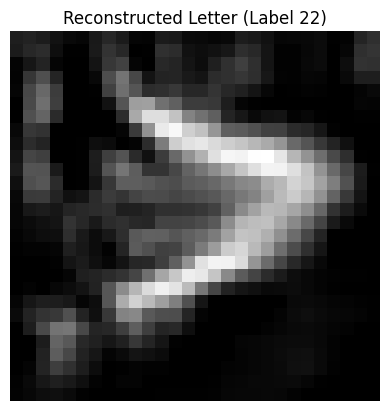


🔍 Prediction Analysis for class 22:
Predicted class: 22
Confidence in target class (22): 0.9994

📊 Similarity Metrics for class 22:
MSE (pixel-wise): 0.0538
SSIM (structural): 0.2949


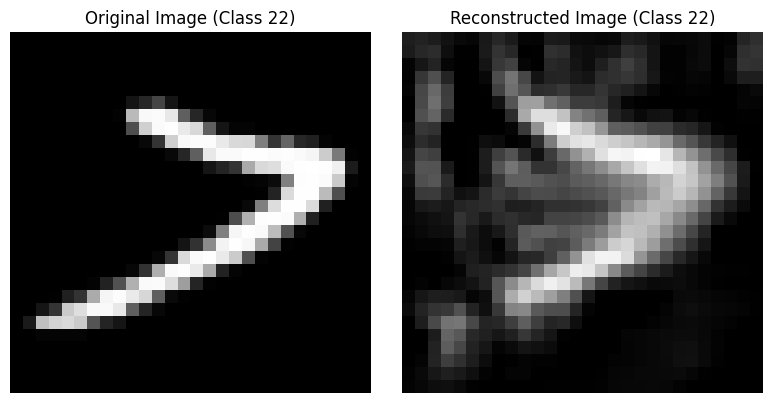


Performing inversion attack for class 23...
Step 0 | Total Loss: 0.0906 | CE: 0.0028 | L2: 0.0065 | Perceptual: 0.0455 | TV: 0.0357
Step 100 | Total Loss: 0.0501 | CE: 0.0002 | L2: 0.0053 | Perceptual: 0.0391 | TV: 0.0054
Step 200 | Total Loss: 0.0473 | CE: 0.0001 | L2: 0.0049 | Perceptual: 0.0378 | TV: 0.0045
Step 300 | Total Loss: 0.0456 | CE: 0.0001 | L2: 0.0045 | Perceptual: 0.0368 | TV: 0.0042
Step 400 | Total Loss: 0.0444 | CE: 0.0001 | L2: 0.0041 | Perceptual: 0.0362 | TV: 0.0040
Step 500 | Total Loss: 0.0434 | CE: 0.0002 | L2: 0.0038 | Perceptual: 0.0357 | TV: 0.0037
Step 600 | Total Loss: 0.0427 | CE: 0.0002 | L2: 0.0035 | Perceptual: 0.0356 | TV: 0.0034
Step 700 | Total Loss: 0.0422 | CE: 0.0003 | L2: 0.0032 | Perceptual: 0.0355 | TV: 0.0033
Step 800 | Total Loss: 0.0418 | CE: 0.0002 | L2: 0.0029 | Perceptual: 0.0354 | TV: 0.0032
Step 900 | Total Loss: 0.0418 | CE: 0.0002 | L2: 0.0027 | Perceptual: 0.0359 | TV: 0.0030
Step 1000 | Total Loss: 0.0417 | CE: 0.0002 | L2: 0.0025 

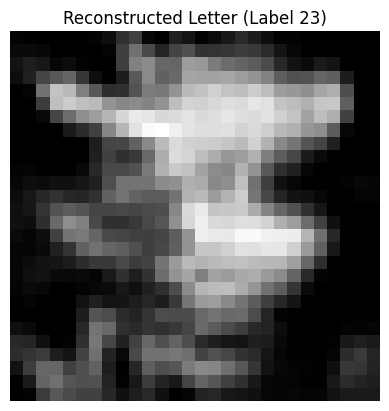


🔍 Prediction Analysis for class 23:
Predicted class: 23
Confidence in target class (23): 0.9997

📊 Similarity Metrics for class 23:
MSE (pixel-wise): 0.1894
SSIM (structural): 0.1131


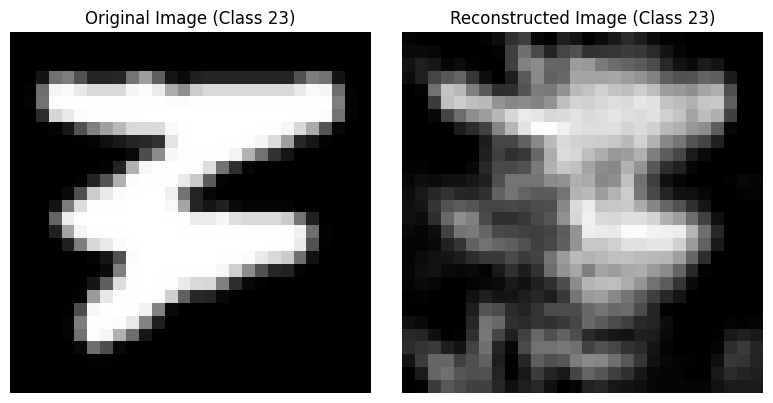


Performing inversion attack for class 24...
Step 0 | Total Loss: 0.0660 | CE: 0.0004 | L2: 0.0072 | Perceptual: 0.0207 | TV: 0.0377
Step 100 | Total Loss: 0.0176 | CE: 0.0001 | L2: 0.0041 | Perceptual: 0.0078 | TV: 0.0055
Step 200 | Total Loss: 0.0169 | CE: 0.0002 | L2: 0.0033 | Perceptual: 0.0081 | TV: 0.0054
Step 300 | Total Loss: 0.0169 | CE: 0.0002 | L2: 0.0030 | Perceptual: 0.0086 | TV: 0.0051
Step 400 | Total Loss: 0.0170 | CE: 0.0003 | L2: 0.0028 | Perceptual: 0.0092 | TV: 0.0048
Step 500 | Total Loss: 0.0171 | CE: 0.0003 | L2: 0.0026 | Perceptual: 0.0096 | TV: 0.0046
Step 600 | Total Loss: 0.0170 | CE: 0.0003 | L2: 0.0026 | Perceptual: 0.0095 | TV: 0.0046
Step 700 | Total Loss: 0.0170 | CE: 0.0003 | L2: 0.0025 | Perceptual: 0.0096 | TV: 0.0046
Step 800 | Total Loss: 0.0171 | CE: 0.0003 | L2: 0.0025 | Perceptual: 0.0098 | TV: 0.0045
Step 900 | Total Loss: 0.0171 | CE: 0.0003 | L2: 0.0024 | Perceptual: 0.0102 | TV: 0.0043
Step 1000 | Total Loss: 0.0172 | CE: 0.0003 | L2: 0.0023 

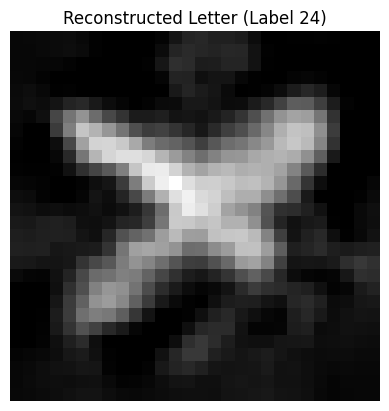


🔍 Prediction Analysis for class 24:
Predicted class: 24
Confidence in target class (24): 0.9997

📊 Similarity Metrics for class 24:
MSE (pixel-wise): 0.0547
SSIM (structural): 0.4055


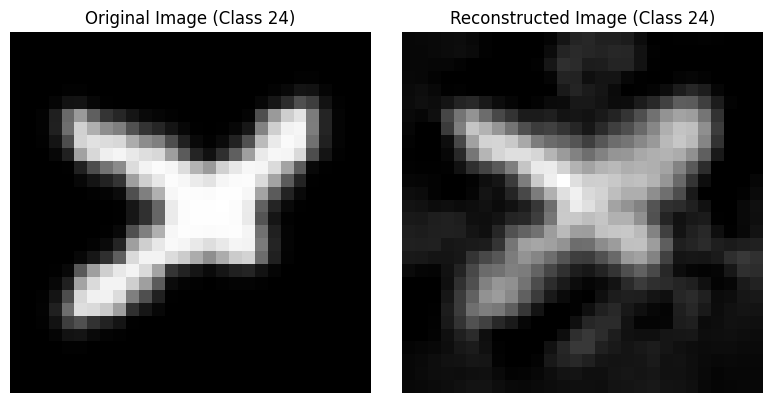


Performing inversion attack for class 25...
Step 0 | Total Loss: 3.1334 | CE: 3.0482 | L2: 0.0045 | Perceptual: 0.0451 | TV: 0.0356
Step 100 | Total Loss: 0.0480 | CE: 0.0005 | L2: 0.0034 | Perceptual: 0.0409 | TV: 0.0032
Step 200 | Total Loss: 0.0451 | CE: 0.0004 | L2: 0.0031 | Perceptual: 0.0392 | TV: 0.0025
Step 300 | Total Loss: 0.0426 | CE: 0.0004 | L2: 0.0028 | Perceptual: 0.0371 | TV: 0.0023
Step 400 | Total Loss: 0.0405 | CE: 0.0003 | L2: 0.0025 | Perceptual: 0.0354 | TV: 0.0023
Step 500 | Total Loss: 0.0384 | CE: 0.0003 | L2: 0.0023 | Perceptual: 0.0333 | TV: 0.0024
Step 600 | Total Loss: 0.0366 | CE: 0.0003 | L2: 0.0022 | Perceptual: 0.0315 | TV: 0.0026
Step 700 | Total Loss: 0.0354 | CE: 0.0003 | L2: 0.0021 | Perceptual: 0.0302 | TV: 0.0028
Step 800 | Total Loss: 0.0346 | CE: 0.0003 | L2: 0.0020 | Perceptual: 0.0292 | TV: 0.0030
Step 900 | Total Loss: 0.0349 | CE: 0.0003 | L2: 0.0019 | Perceptual: 0.0299 | TV: 0.0028
Step 1000 | Total Loss: 0.0348 | CE: 0.0003 | L2: 0.0018 

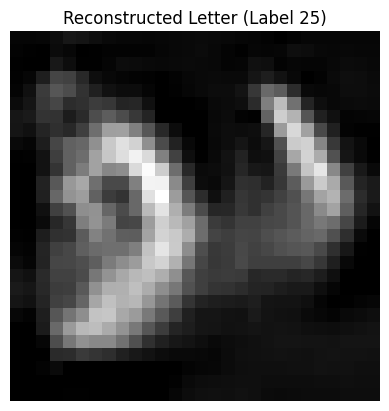


🔍 Prediction Analysis for class 25:
Predicted class: 25
Confidence in target class (25): 0.9998

📊 Similarity Metrics for class 25:
MSE (pixel-wise): 0.0993
SSIM (structural): 0.2321


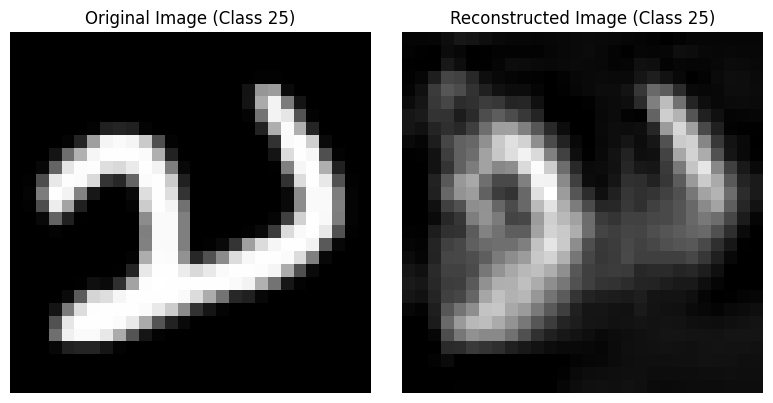


Performing inversion attack for class 26...
Step 0 | Total Loss: 3.2015 | CE: 3.1146 | L2: 0.0072 | Perceptual: 0.0438 | TV: 0.0359
Step 100 | Total Loss: 0.0522 | CE: 0.0005 | L2: 0.0061 | Perceptual: 0.0408 | TV: 0.0048
Step 200 | Total Loss: 0.0504 | CE: 0.0003 | L2: 0.0057 | Perceptual: 0.0402 | TV: 0.0042
Step 300 | Total Loss: 0.0494 | CE: 0.0003 | L2: 0.0053 | Perceptual: 0.0399 | TV: 0.0040
Step 400 | Total Loss: 0.0475 | CE: 0.0002 | L2: 0.0050 | Perceptual: 0.0384 | TV: 0.0039
Step 500 | Total Loss: 0.0457 | CE: 0.0001 | L2: 0.0047 | Perceptual: 0.0369 | TV: 0.0040
Step 600 | Total Loss: 0.0438 | CE: 0.0001 | L2: 0.0045 | Perceptual: 0.0353 | TV: 0.0039
Step 700 | Total Loss: 0.0424 | CE: 0.0002 | L2: 0.0042 | Perceptual: 0.0343 | TV: 0.0037
Step 800 | Total Loss: 0.0412 | CE: 0.0002 | L2: 0.0039 | Perceptual: 0.0335 | TV: 0.0036
Step 900 | Total Loss: 0.0410 | CE: 0.0002 | L2: 0.0037 | Perceptual: 0.0338 | TV: 0.0033
Step 1000 | Total Loss: 0.0404 | CE: 0.0002 | L2: 0.0035 

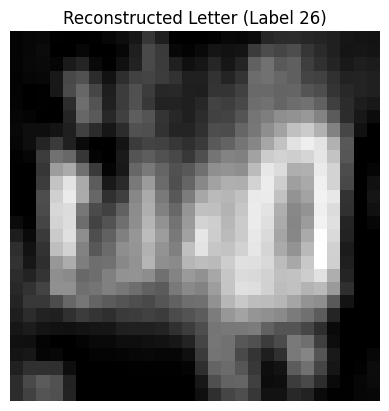


🔍 Prediction Analysis for class 26:
Predicted class: 26
Confidence in target class (26): 0.9998

📊 Similarity Metrics for class 26:
MSE (pixel-wise): 0.0608
SSIM (structural): 0.1374


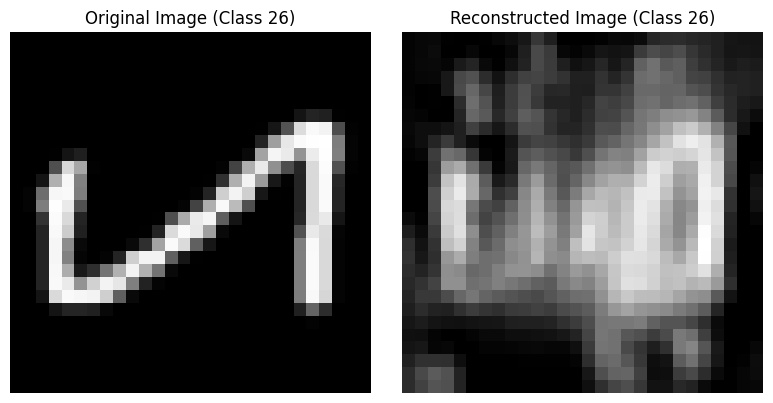

In [2]:










# -----------------------------------
# 4. White-Box Inversion Attack (for All Classes)
# -----------------------------------
for target_label in range(1, 27):  # Loop over all classes (1-26 for A-Z)
    target_class = torch.tensor([target_label - 1], dtype=torch.long).to(device)  # Adjust label to 0-indexed

    # Initialize with mean image of the target letter + noise
    mean_img = torch.zeros((1, 1, 28, 28), device=device)
    count = 0
    for img, label in train_dataset:
        if label == target_label:
            mean_img += img.to(device)
            count += 1
    mean_img /= count
    reconstructed_img = (mean_img + torch.randn_like(mean_img) * 0.1).requires_grad_(True)

    # Optimizer and scheduler
    optimizer = optim.AdamW([reconstructed_img], lr=0.005)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=800, gamma=0.7)
    loss_fn = nn.CrossEntropyLoss()



    # Total Variation Loss
    def tv_loss(img):
        h_var = torch.sum((img[:, :, 1:, :] - img[:, :, :-1, :])**2)
        w_var = torch.sum((img[:, :, :, 1:] - img[:, :, :, :-1])**2)
        return h_var + w_var

    # Gaussian smoothing
    def gaussian_blur(img):
        kernel = torch.tensor([[1, 2, 1], [2, 4, 2], [1, 2, 1]], dtype=torch.float32, device=device) / 16
        kernel = kernel.view(1, 1, 3, 3)
        return F.conv2d(img, kernel, padding=1)

    # Get real features of the target letter
    target_image = None
    for img, label in train_dataset:
        if label == target_label:
            target_image = img
            break

    if target_image is None:
        raise ValueError(f"Target label {target_label} not found in dataset.")

    target_image = target_image.unsqueeze(0).to(device)
    target_features = model.get_features(target_image)

    # -----------------------------------
    # Inversion Loop
    # -----------------------------------
# -----------------------------------
# Inversion Attack for All Classes
# -----------------------------------
for target_label in range(1, 27):  # Loop over all 26 classes (A-Z)
    print(f"\nPerforming inversion attack for class {target_label}...")

    # Define the target class
    target_class = torch.tensor([target_label - 1], dtype=torch.long).to(device)

    # Initialize with mean image of the target letter + noise
    mean_img = torch.zeros((1, 1, 28, 28), device=device)
    count = 0
    for img, label in train_dataset:
        if label == target_label:
            mean_img += img.to(device)
            count += 1
    mean_img /= count
    reconstructed_img = (mean_img + torch.randn_like(mean_img) * 0.1).requires_grad_(True)

    # Optimizer and scheduler for the reconstruction process
    optimizer = optim.AdamW([reconstructed_img], lr=0.005)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=800, gamma=0.7)
    loss_fn = nn.CrossEntropyLoss()

    # Total Variation Loss
    def tv_loss(img):
        h_var = torch.sum((img[:, :, 1:, :] - img[:, :, :-1, :])**2)
        w_var = torch.sum((img[:, :, :, 1:] - img[:, :, :, :-1])**2)
        return h_var + w_var

    # Gaussian smoothing function
    def gaussian_blur(img):
        kernel = torch.tensor([[1, 2, 1], [2, 4, 2], [1, 2, 1]], dtype=torch.float32, device=device) / 16
        kernel = kernel.view(1, 1, 3, 3)
        return F.conv2d(img, kernel, padding=1)

    # Get real features of the target letter
    target_image = None
    for img, label in train_dataset:
        if label == target_label:
            target_image = img
            break

    if target_image is None:
        raise ValueError(f"Target label {target_label} not found in dataset.")

    target_image = target_image.unsqueeze(0).to(device)
    target_features = model.get_features(target_image)

    # -----------------------------------
    # Inversion Loop
    # -----------------------------------
    for step in range(2500):  # Set the number of steps for inversion
        optimizer.zero_grad()
        output = model(reconstructed_img)
        loss = loss_fn(output, target_class)
        l2_loss = torch.sum(reconstructed_img ** 2) * 0.0001
        reconstructed_features = model.get_features(reconstructed_img)[0]
        perceptual_loss = F.mse_loss(reconstructed_features, target_features) * 0.5
        tv = tv_loss(reconstructed_img) * 0.001
        total_loss = loss + l2_loss + perceptual_loss + tv
        total_loss.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_([reconstructed_img], 5.0)
        optimizer.step()
        scheduler.step()

        with torch.no_grad():
            reconstructed_img.clamp_(0, 1)
            if step % 50 == 0:
                reconstructed_img.copy_(gaussian_blur(reconstructed_img).clamp_(0, 1))

        if step % 100 == 0:
            print(f"Step {step} | Total Loss: {total_loss.item():.4f} | CE: {loss.item():.4f} | "
                  f"L2: {l2_loss.item():.4f} | Perceptual: {perceptual_loss.item():.4f} | TV: {tv.item():.4f}")
            plt.imshow(reconstructed_img.squeeze().detach().cpu(), cmap='gray')
            plt.title(f"Step {step} - Class {target_label}")
            plt.axis('off')
            plt.savefig(f"emnist_reconstructed_step_{target_label}_step_{step}.png")
            plt.close()

    # -----------------------------------
    # Final Visualization
    # -----------------------------------
    plt.imshow(reconstructed_img.squeeze().detach().cpu(), cmap='gray')
    plt.title(f"Reconstructed Letter (Label {target_label})")
    plt.axis('off')
    plt.savefig(f'emnist_reconstructed_final_{target_label}.png')
    plt.show()

    # -----------------------------------
    # Evaluation of the Reconstruction
    # -----------------------------------
    with torch.no_grad():
        probs = F.softmax(model(reconstructed_img), dim=1)
        confidence = probs[0, target_label - 1].item()
        predicted_class = torch.argmax(probs).item()

    print(f"\n🔍 Prediction Analysis for class {target_label}:")
    print(f"Predicted class: {predicted_class + 1}")
    print(f"Confidence in target class ({target_label}): {confidence:.4f}")

    # Calculate similarity metrics
    original_np = target_image.squeeze().cpu().numpy()
    reconstructed_np = reconstructed_img.squeeze().detach().cpu().numpy()

    mse_val = np.mean((original_np - reconstructed_np) ** 2)
    ssim_val = ssim(original_np, reconstructed_np, data_range=1.0)

    print(f"\n📊 Similarity Metrics for class {target_label}:")
    print(f"MSE (pixel-wise): {mse_val:.4f}")
    print(f"SSIM (structural): {ssim_val:.4f}")

    # Visualize comparison
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(original_np, cmap='gray')
    axes[0].set_title(f"Original Image (Class {target_label})")
    axes[0].axis('off')

    axes[1].imshow(reconstructed_np, cmap='gray')
    axes[1].set_title(f"Reconstructed Image (Class {target_label})")
    axes[1].axis('off')

    plt.tight_layout()
    plt.savefig(f'emnist_comparison_class_{target_label}.png')
    plt.show()


In [4]:
pip install emnist

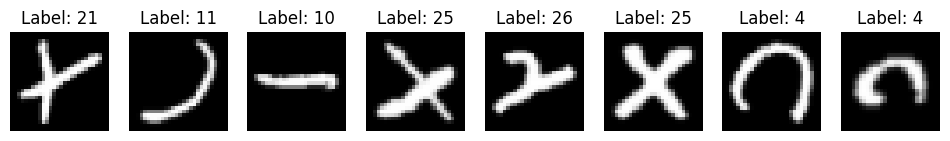

In [6]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations (convert images to tensor)
transform = transforms.Compose([transforms.ToTensor()])

# Load the EMNIST Letters Dataset (train data)
train_dataset = datasets.EMNIST(root='./data', split='letters', train=True, download=True, transform=transform)

# Create DataLoader (batch size is 8 for visualization)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Function to display images
def show_samples():
    # Get a batch of images and labels
    images, labels = next(iter(train_loader))

    # Plot the images
    fig, axes = plt.subplots(1, 8, figsize=(12, 12))
    for i in range(8):
        ax = axes[i]
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(f"Label: {labels[i].item() + 1}")  # EMNIST labels are 1-based
        ax.axis('off')
    plt.show()

# Show samples from the dataset
show_samples()

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
import numpy as np
import os

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# -----------------------------------
# 1. Load EMNIST Letters Dataset
# -----------------------------------
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.EMNIST(root='./data', split='letters', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = datasets.EMNIST(root='./data', split='letters', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# -----------------------------------
# 2. Define a simple CNN model
# -----------------------------------
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 26)  # 26 classes (A-Z)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def get_features(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x

model = SimpleCNN().to(device)

# -----------------------------------
# 3. Train the model (if no saved model)
# -----------------------------------
model_path = 'emnist_cnn.pth'
if not os.path.exists(model_path):
    print("Training model...")
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()
    model.train()
    for epoch in range(10):
        total_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = loss_fn(outputs, labels - 1)  # EMNIST labels start from 1
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")
    torch.save(model.state_dict(), model_path)
else:
    print("Loading existing model...")
    model.load_state_dict(torch.load(model_path, map_location=device))

model.eval()

# -----------------------------------
# Evaluate on the test set
# -----------------------------------
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        predicted = outputs.argmax(dim=1)
        correct += (predicted == (labels - 1)).sum().item()  # labels - 1 because EMNIST labels start at 1
        total += labels.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy*100:.2f}%")

# -----------------------------------
# 4. White-Box Inversion Attack (for All Classes)
# -----------------------------------
# Total Variation Loss
def tv_loss(img):
    h_var = torch.sum((img[:, :, 1:, :] - img[:, :, :-1, :])**2)
    w_var = torch.sum((img[:, :, :, 1:] - img[:, :, :, :-1])**2)
    return h_var + w_var

# Gaussian smoothing
def gaussian_blur(img):
    kernel = torch.tensor([[1, 2, 1], [2, 4, 2], [1, 2, 1]], dtype=torch.float32, device=device) / 16
    kernel = kernel.view(1, 1, 3, 3)
    return F.conv2d(img, kernel, padding=1)

# Inversion Attack for All Classes
for target_label in range(1, 27):  # Loop over all 26 classes (A-Z)
    print(f"\nPerforming inversion attack for class {target_label}...")

    # Define the target class
    target_class = torch.tensor([target_label - 1], dtype=torch.long).to(device)

    # Initialize with a specific sample + noise (instead of mean image)
    target_image = None
    for img, label in train_dataset:
        if label == target_label:
            target_image = img
            break

    if target_image is None:
        raise ValueError(f"Target label {target_label} not found in dataset.")

    target_image = target_image.unsqueeze(0).to(device)
    reconstructed_img = (target_image + torch.randn_like(target_image) * 0.05).requires_grad_(True)

    # Optimizer and scheduler for the reconstruction process
    optimizer = optim.AdamW([reconstructed_img], lr=0.005)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=800, gamma=0.9)  # Adjusted gamma
    loss_fn = nn.CrossEntropyLoss()

    # Get real features of the target letter
    target_features = model.get_features(target_image)

    # -----------------------------------
    # Inversion Loop
    # -----------------------------------
    for step in range(5000):  # Increased steps for better optimization
        optimizer.zero_grad()
        output = model(reconstructed_img)
        loss = loss_fn(output, target_class)
        l2_loss = torch.sum(reconstructed_img ** 2) * 0.00001  # Reduced L2 weight
        reconstructed_features = model.get_features(reconstructed_img)[0]
        perceptual_loss = F.mse_loss(reconstructed_features, target_features) * 1.0  # Increased weight
        tv = tv_loss(reconstructed_img) * 0.0001  # Reduced TV weight
        total_loss = loss + l2_loss + perceptual_loss + tv
        total_loss.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_([reconstructed_img], 5.0)
        optimizer.step()
        scheduler.step()

        with torch.no_grad():
            reconstructed_img.clamp_(0, 1)
            if step % 100 == 0:  # Reduced blur frequency (from 50 to 100)
                reconstructed_img.copy_(gaussian_blur(reconstructed_img).clamp_(0, 1))

        if step % 100 == 0:
            print(f"Step {step} | Total Loss: {total_loss.item():.4f} | CE: {loss.item():.4f} | "
                  f"L2: {l2_loss.item():.4f} | Perceptual: {perceptual_loss.item():.4f} | TV: {tv.item():.4f}")
            plt.imshow(reconstructed_img.squeeze().detach().cpu(), cmap='gray')
            plt.title(f"Step {step} - Class {target_label}")
            plt.axis('off')
            plt.savefig(f"emnist_reconstructed_step_{target_label}_step_{step}.png")
            plt.close()

    # -----------------------------------
    # Final Visualization
    # -----------------------------------
    plt.imshow(reconstructed_img.squeeze().detach().cpu(), cmap='gray')
    plt.title(f"Reconstructed Letter (Label {target_label})")
    plt.axis('off')
    plt.savefig(f'emnist_reconstructed_final_{target_label}.png')
    plt.close()

    # -----------------------------------
    # Evaluation of the Reconstruction
    # -----------------------------------
    with torch.no_grad():
        probs = F.softmax(model(reconstructed_img), dim=1)
        confidence = probs[0, target_label - 1].item()
        predicted_class = torch.argmax(probs).item()

    print(f"\n🔍 Prediction Analysis for class {target_label}:")
    print(f"Predicted class: {predicted_class + 1}")
    print(f"Confidence in target class ({target_label}): {confidence:.4f}")

    # Calculate similarity metrics
    original_np = target_image.squeeze().cpu().numpy()
    reconstructed_np = reconstructed_img.squeeze().detach().cpu().numpy()

    mse_val = np.mean((original_np - reconstructed_np) ** 2)
    ssim_val = ssim(original_np, reconstructed_np, data_range=1.0)

    print(f"\n📊 Similarity Metrics for class {target_label}:")
    print(f"MSE (pixel-wise): {mse_val:.4f}")
    print(f"SSIM (structural): {ssim_val:.4f}")

    # Visualize comparison
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(original_np, cmap='gray')
    axes[0].set_title(f"Original Image (Class {target_label})")
    axes[0].axis('off')

    axes[1].imshow(reconstructed_np, cmap='gray')
    axes[1].set_title(f"Reconstructed Image (Class {target_label})")
    axes[1].axis('off')

    plt.tight_layout()
    plt.savefig(f'emnist_comparison_class_{target_label}.png')
    plt.close()

Using device: cuda
Training model...
Epoch 1, Loss: 0.4991
Epoch 2, Loss: 0.2426
Epoch 3, Loss: 0.1959
Epoch 4, Loss: 0.1663
Epoch 5, Loss: 0.1403
Epoch 6, Loss: 0.1205
Epoch 7, Loss: 0.1036
Epoch 8, Loss: 0.0901
Epoch 9, Loss: 0.0777
Epoch 10, Loss: 0.0711
Test Accuracy: 92.75%

Performing inversion attack for class 1...
Step 0 | Total Loss: 0.0200 | CE: 0.0088 | L2: 0.0015 | Perceptual: 0.0030 | TV: 0.0068


<ipython-input-8-edf48e8fd838>:151: UserWarning: Using a target size (torch.Size([1, 64, 24, 24])) that is different to the input size (torch.Size([64, 24, 24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  perceptual_loss = F.mse_loss(reconstructed_features, target_features) * 1.0  # Increased weight


Step 100 | Total Loss: 0.0071 | CE: 0.0001 | L2: 0.0013 | Perceptual: 0.0011 | TV: 0.0046
Step 200 | Total Loss: 0.0070 | CE: 0.0001 | L2: 0.0012 | Perceptual: 0.0011 | TV: 0.0046
Step 300 | Total Loss: 0.0069 | CE: 0.0001 | L2: 0.0012 | Perceptual: 0.0010 | TV: 0.0046
Step 400 | Total Loss: 0.0069 | CE: 0.0001 | L2: 0.0012 | Perceptual: 0.0010 | TV: 0.0046
Step 500 | Total Loss: 0.0069 | CE: 0.0001 | L2: 0.0012 | Perceptual: 0.0009 | TV: 0.0046
Step 600 | Total Loss: 0.0069 | CE: 0.0001 | L2: 0.0012 | Perceptual: 0.0009 | TV: 0.0046
Step 700 | Total Loss: 0.0069 | CE: 0.0001 | L2: 0.0012 | Perceptual: 0.0009 | TV: 0.0047
Step 800 | Total Loss: 0.0069 | CE: 0.0001 | L2: 0.0012 | Perceptual: 0.0009 | TV: 0.0047
Step 900 | Total Loss: 0.0069 | CE: 0.0001 | L2: 0.0012 | Perceptual: 0.0009 | TV: 0.0047
Step 1000 | Total Loss: 0.0069 | CE: 0.0001 | L2: 0.0012 | Perceptual: 0.0009 | TV: 0.0047
Step 1100 | Total Loss: 0.0069 | CE: 0.0001 | L2: 0.0012 | Perceptual: 0.0009 | TV: 0.0047
Step 120


Displaying comparison image for class 1 (Letter A)


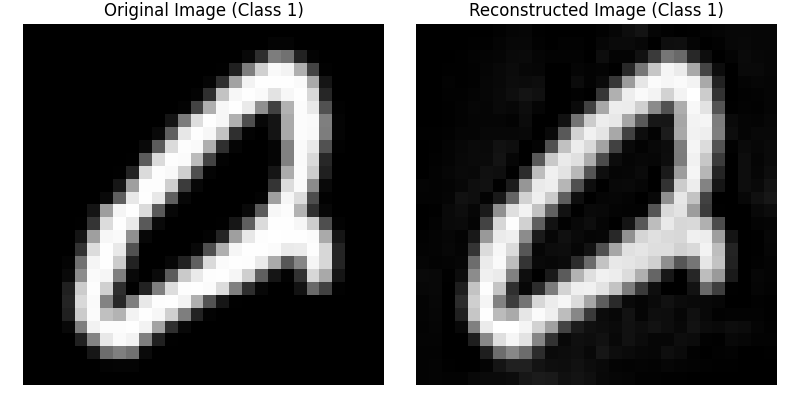


Displaying comparison image for class 2 (Letter B)


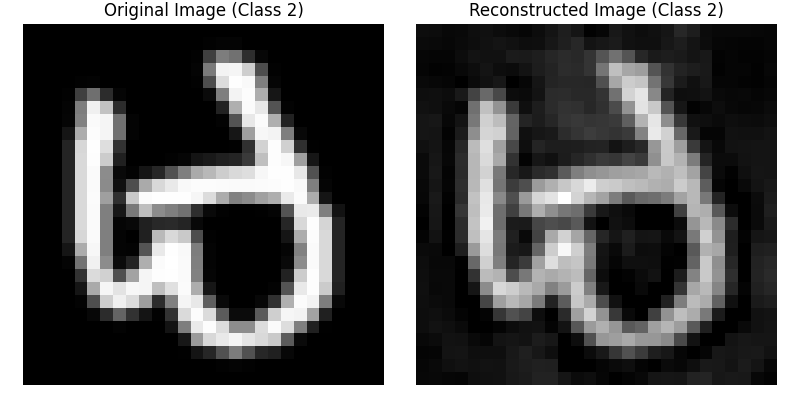


Displaying comparison image for class 3 (Letter C)


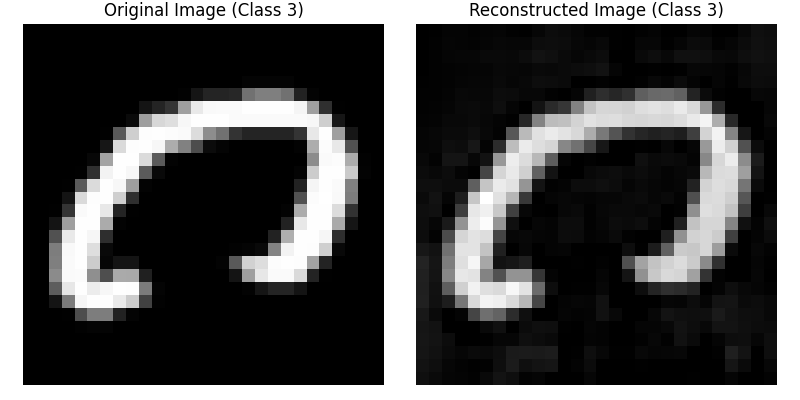


Displaying comparison image for class 4 (Letter D)


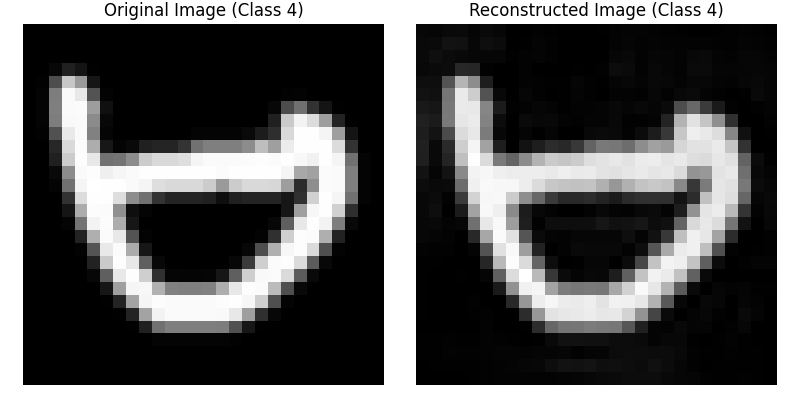


Displaying comparison image for class 5 (Letter E)


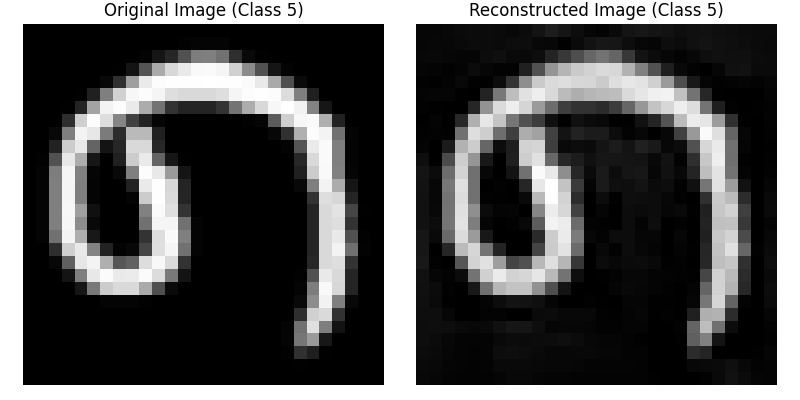


Displaying comparison image for class 6 (Letter F)


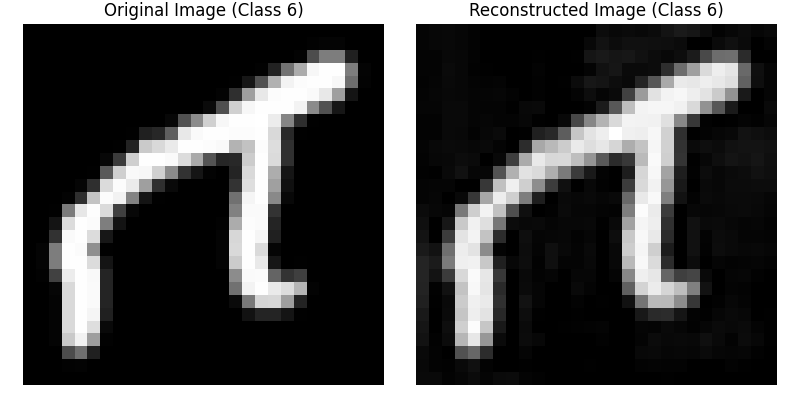


Displaying comparison image for class 7 (Letter G)


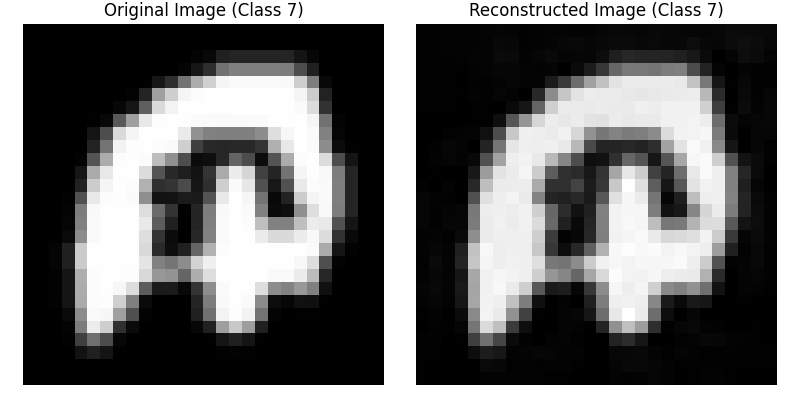


Displaying comparison image for class 8 (Letter H)


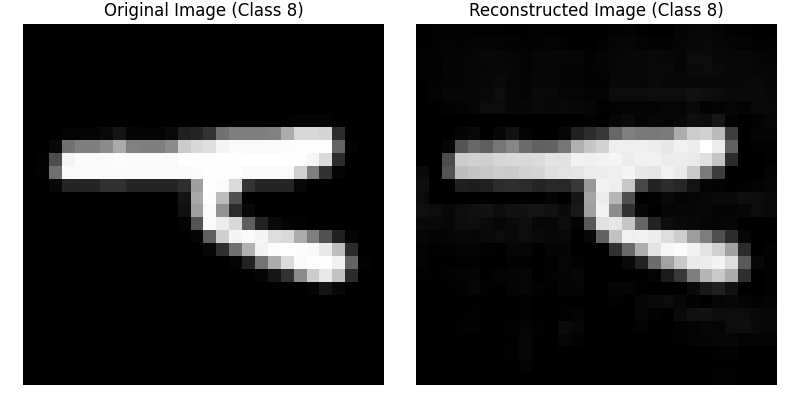


Displaying comparison image for class 9 (Letter I)


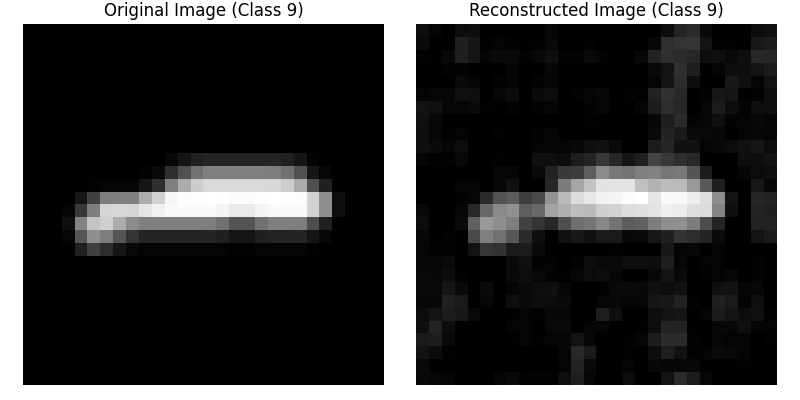


Displaying comparison image for class 10 (Letter J)


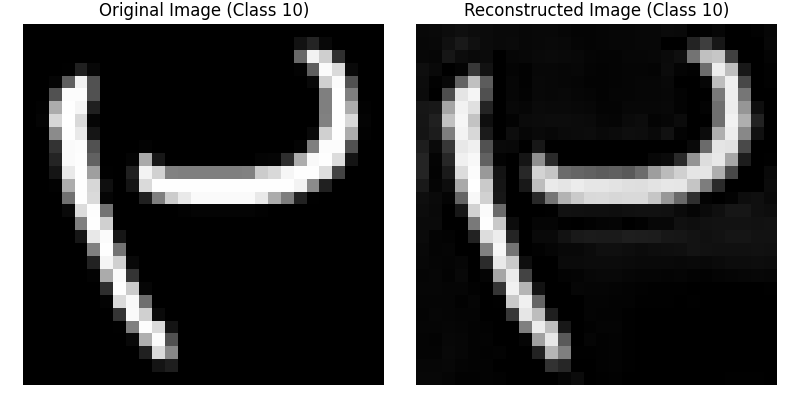


Displaying comparison image for class 11 (Letter K)


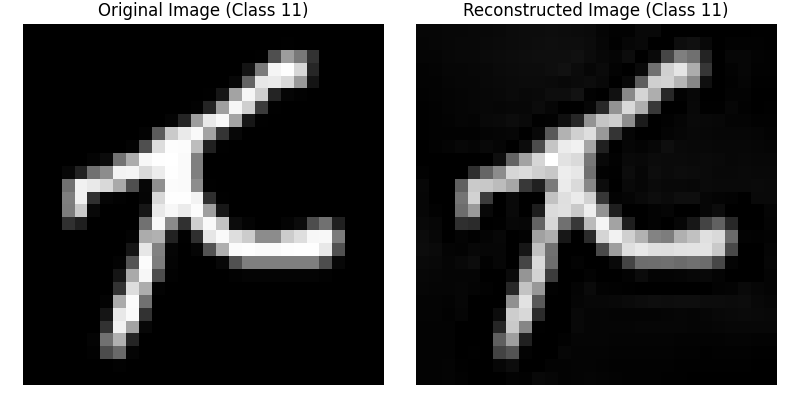


Displaying comparison image for class 12 (Letter L)


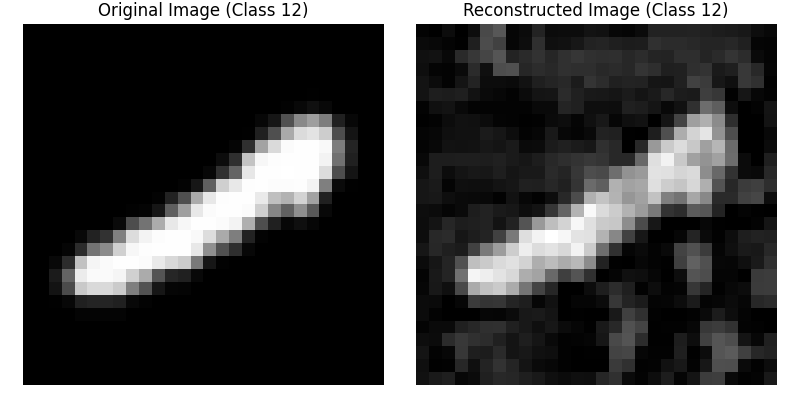


Displaying comparison image for class 13 (Letter M)


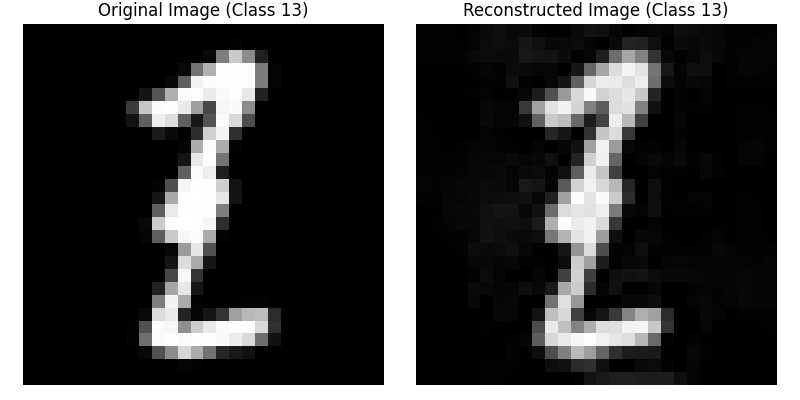


Displaying comparison image for class 14 (Letter N)


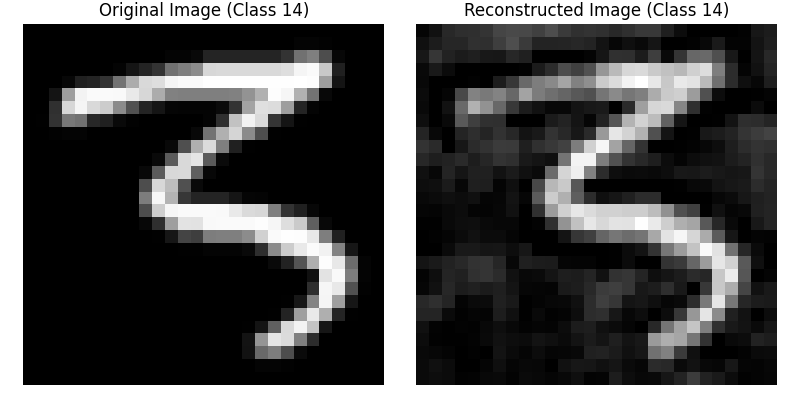


Displaying comparison image for class 15 (Letter O)


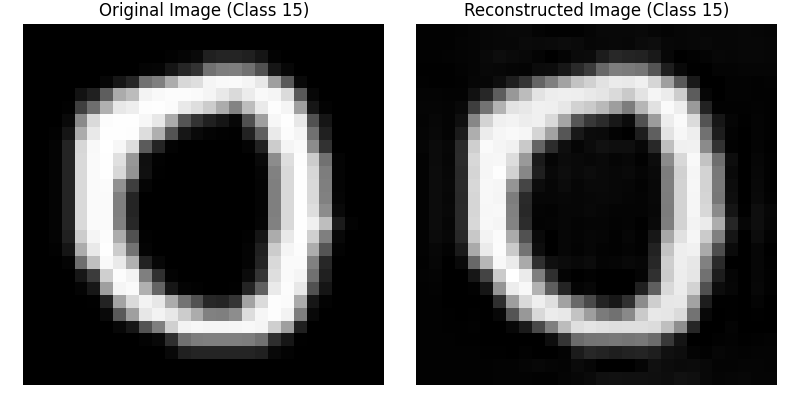


Displaying comparison image for class 16 (Letter P)


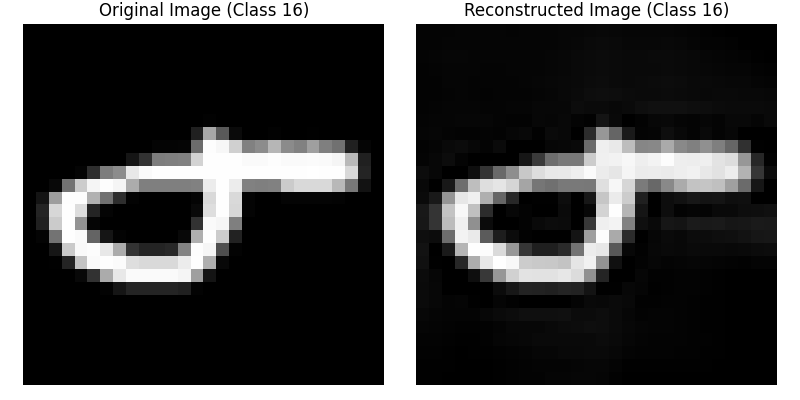


Displaying comparison image for class 17 (Letter Q)


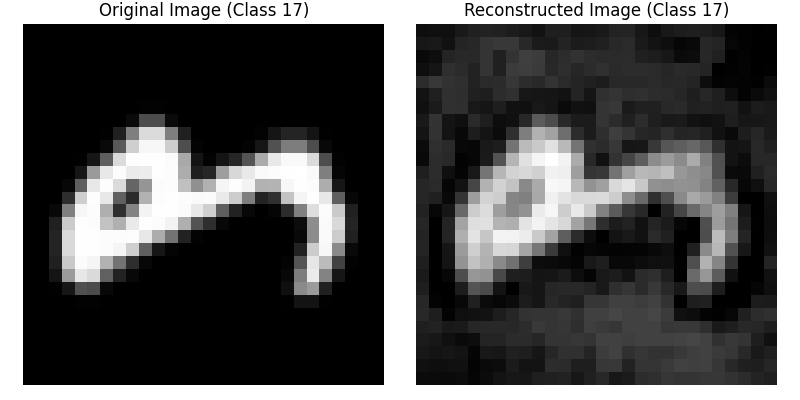


Displaying comparison image for class 18 (Letter R)


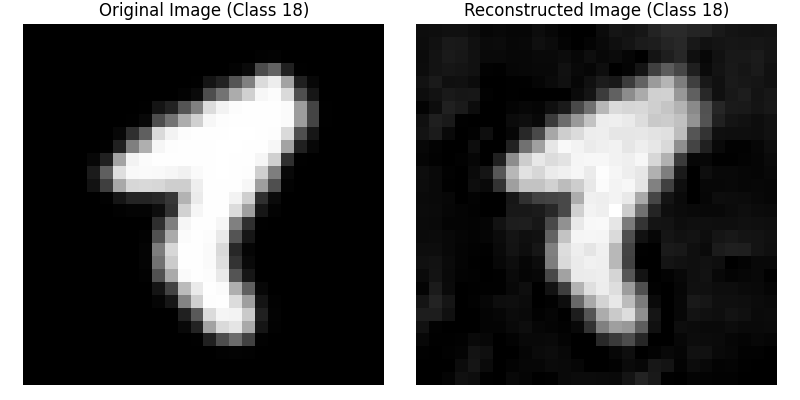


Displaying comparison image for class 19 (Letter S)


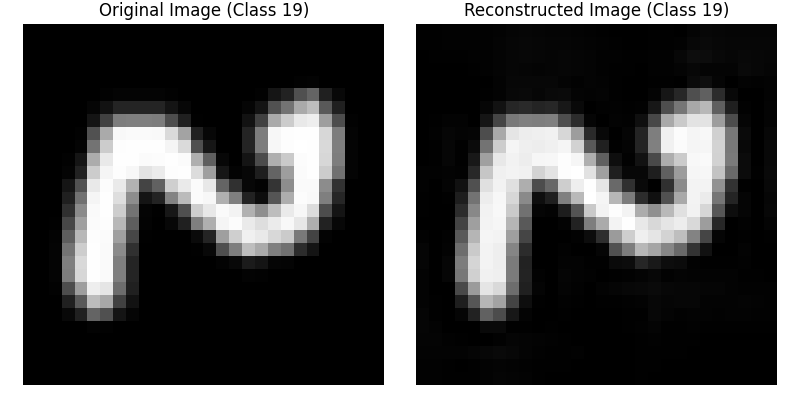


Displaying comparison image for class 20 (Letter T)


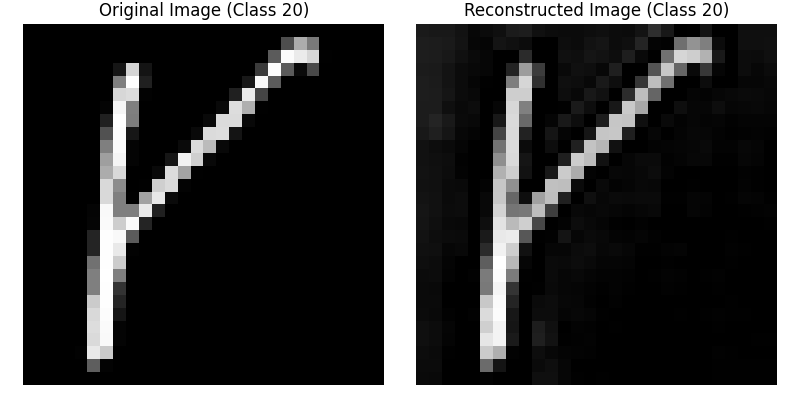


Displaying comparison image for class 21 (Letter U)


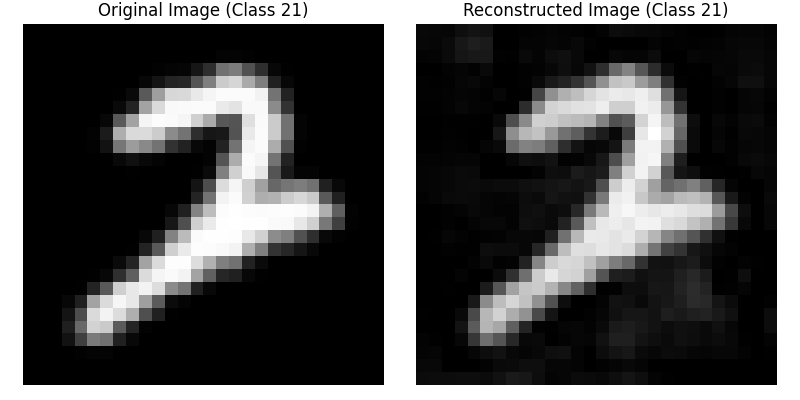


Displaying comparison image for class 22 (Letter V)


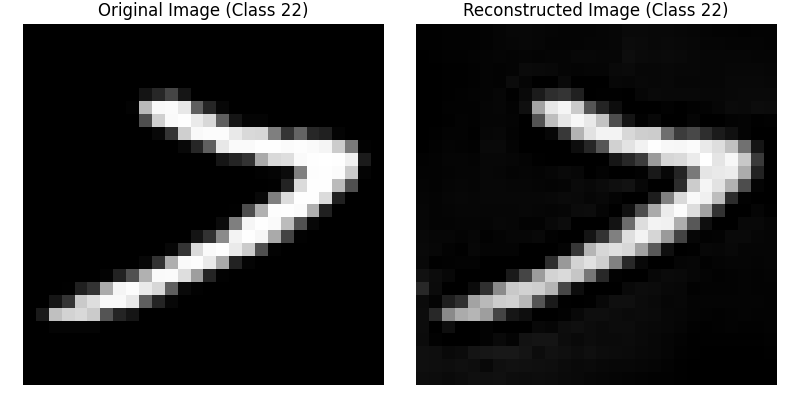


Displaying comparison image for class 23 (Letter W)


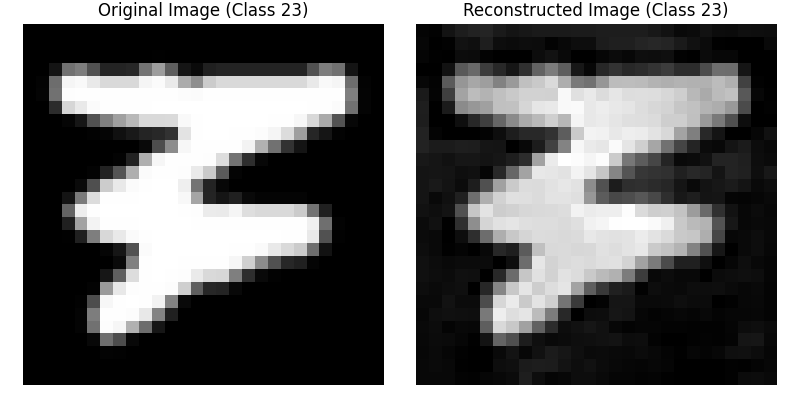


Displaying comparison image for class 24 (Letter X)


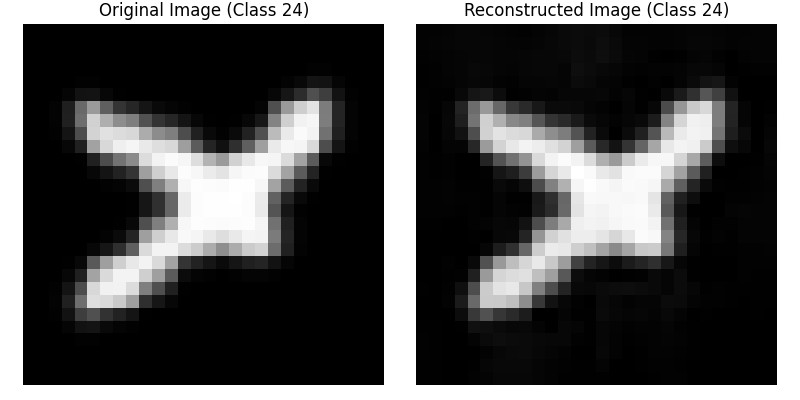


Displaying comparison image for class 25 (Letter Y)


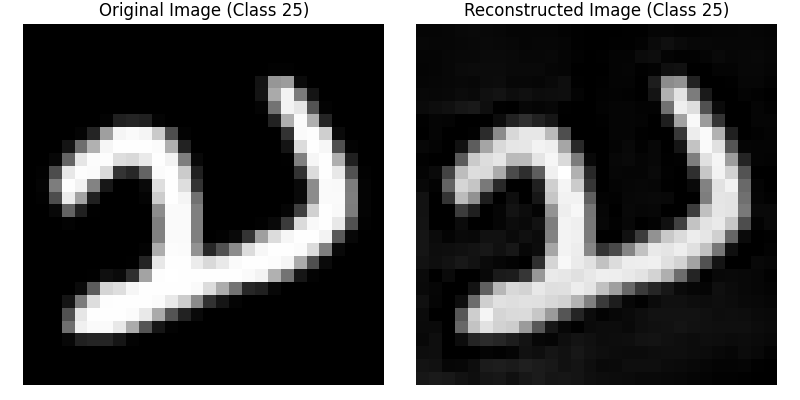


Displaying comparison image for class 26 (Letter Z)


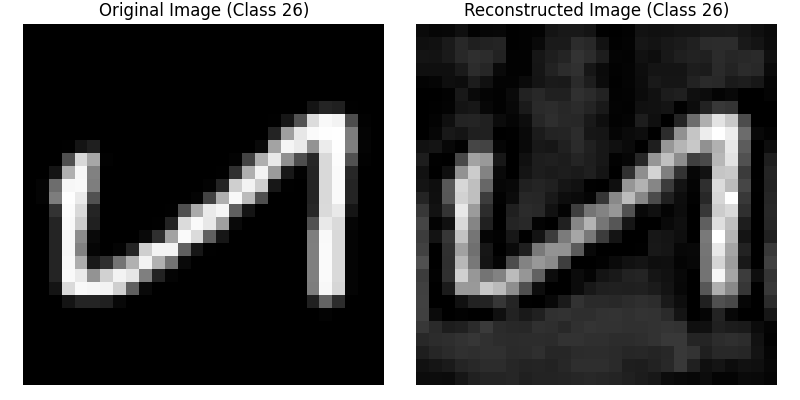

In [11]:
from IPython.display import Image, display
import os

# Loop over all classes (1 to 26 for A-Z)
for target_label in range(1, 27):
    print(f"\nDisplaying comparison image for class {target_label} (Letter {chr(64 + target_label)})")

    # Path to the comparison image
    image_path = f'/content/emnist_comparison_class_{target_label}.png'

    # Check if the image exists
    if os.path.exists(image_path):
        # Display the image in the notebook
        display(Image(filename=image_path))
    else:
        print(f"Image not found at {image_path}")


Processing comparison image for class 1 (Letter A)...

Processing comparison image for class 2 (Letter B)...

Processing comparison image for class 3 (Letter C)...

Processing comparison image for class 4 (Letter D)...

Processing comparison image for class 5 (Letter E)...

Processing comparison image for class 6 (Letter F)...

Processing comparison image for class 7 (Letter G)...

Processing comparison image for class 8 (Letter H)...

Processing comparison image for class 9 (Letter I)...

Processing comparison image for class 10 (Letter J)...

Processing comparison image for class 11 (Letter K)...

Processing comparison image for class 12 (Letter L)...

Processing comparison image for class 13 (Letter M)...

Processing comparison image for class 14 (Letter N)...

Processing comparison image for class 15 (Letter O)...

Processing comparison image for class 16 (Letter P)...

Processing comparison image for class 17 (Letter Q)...

Processing comparison image for class 18 (Letter R)...



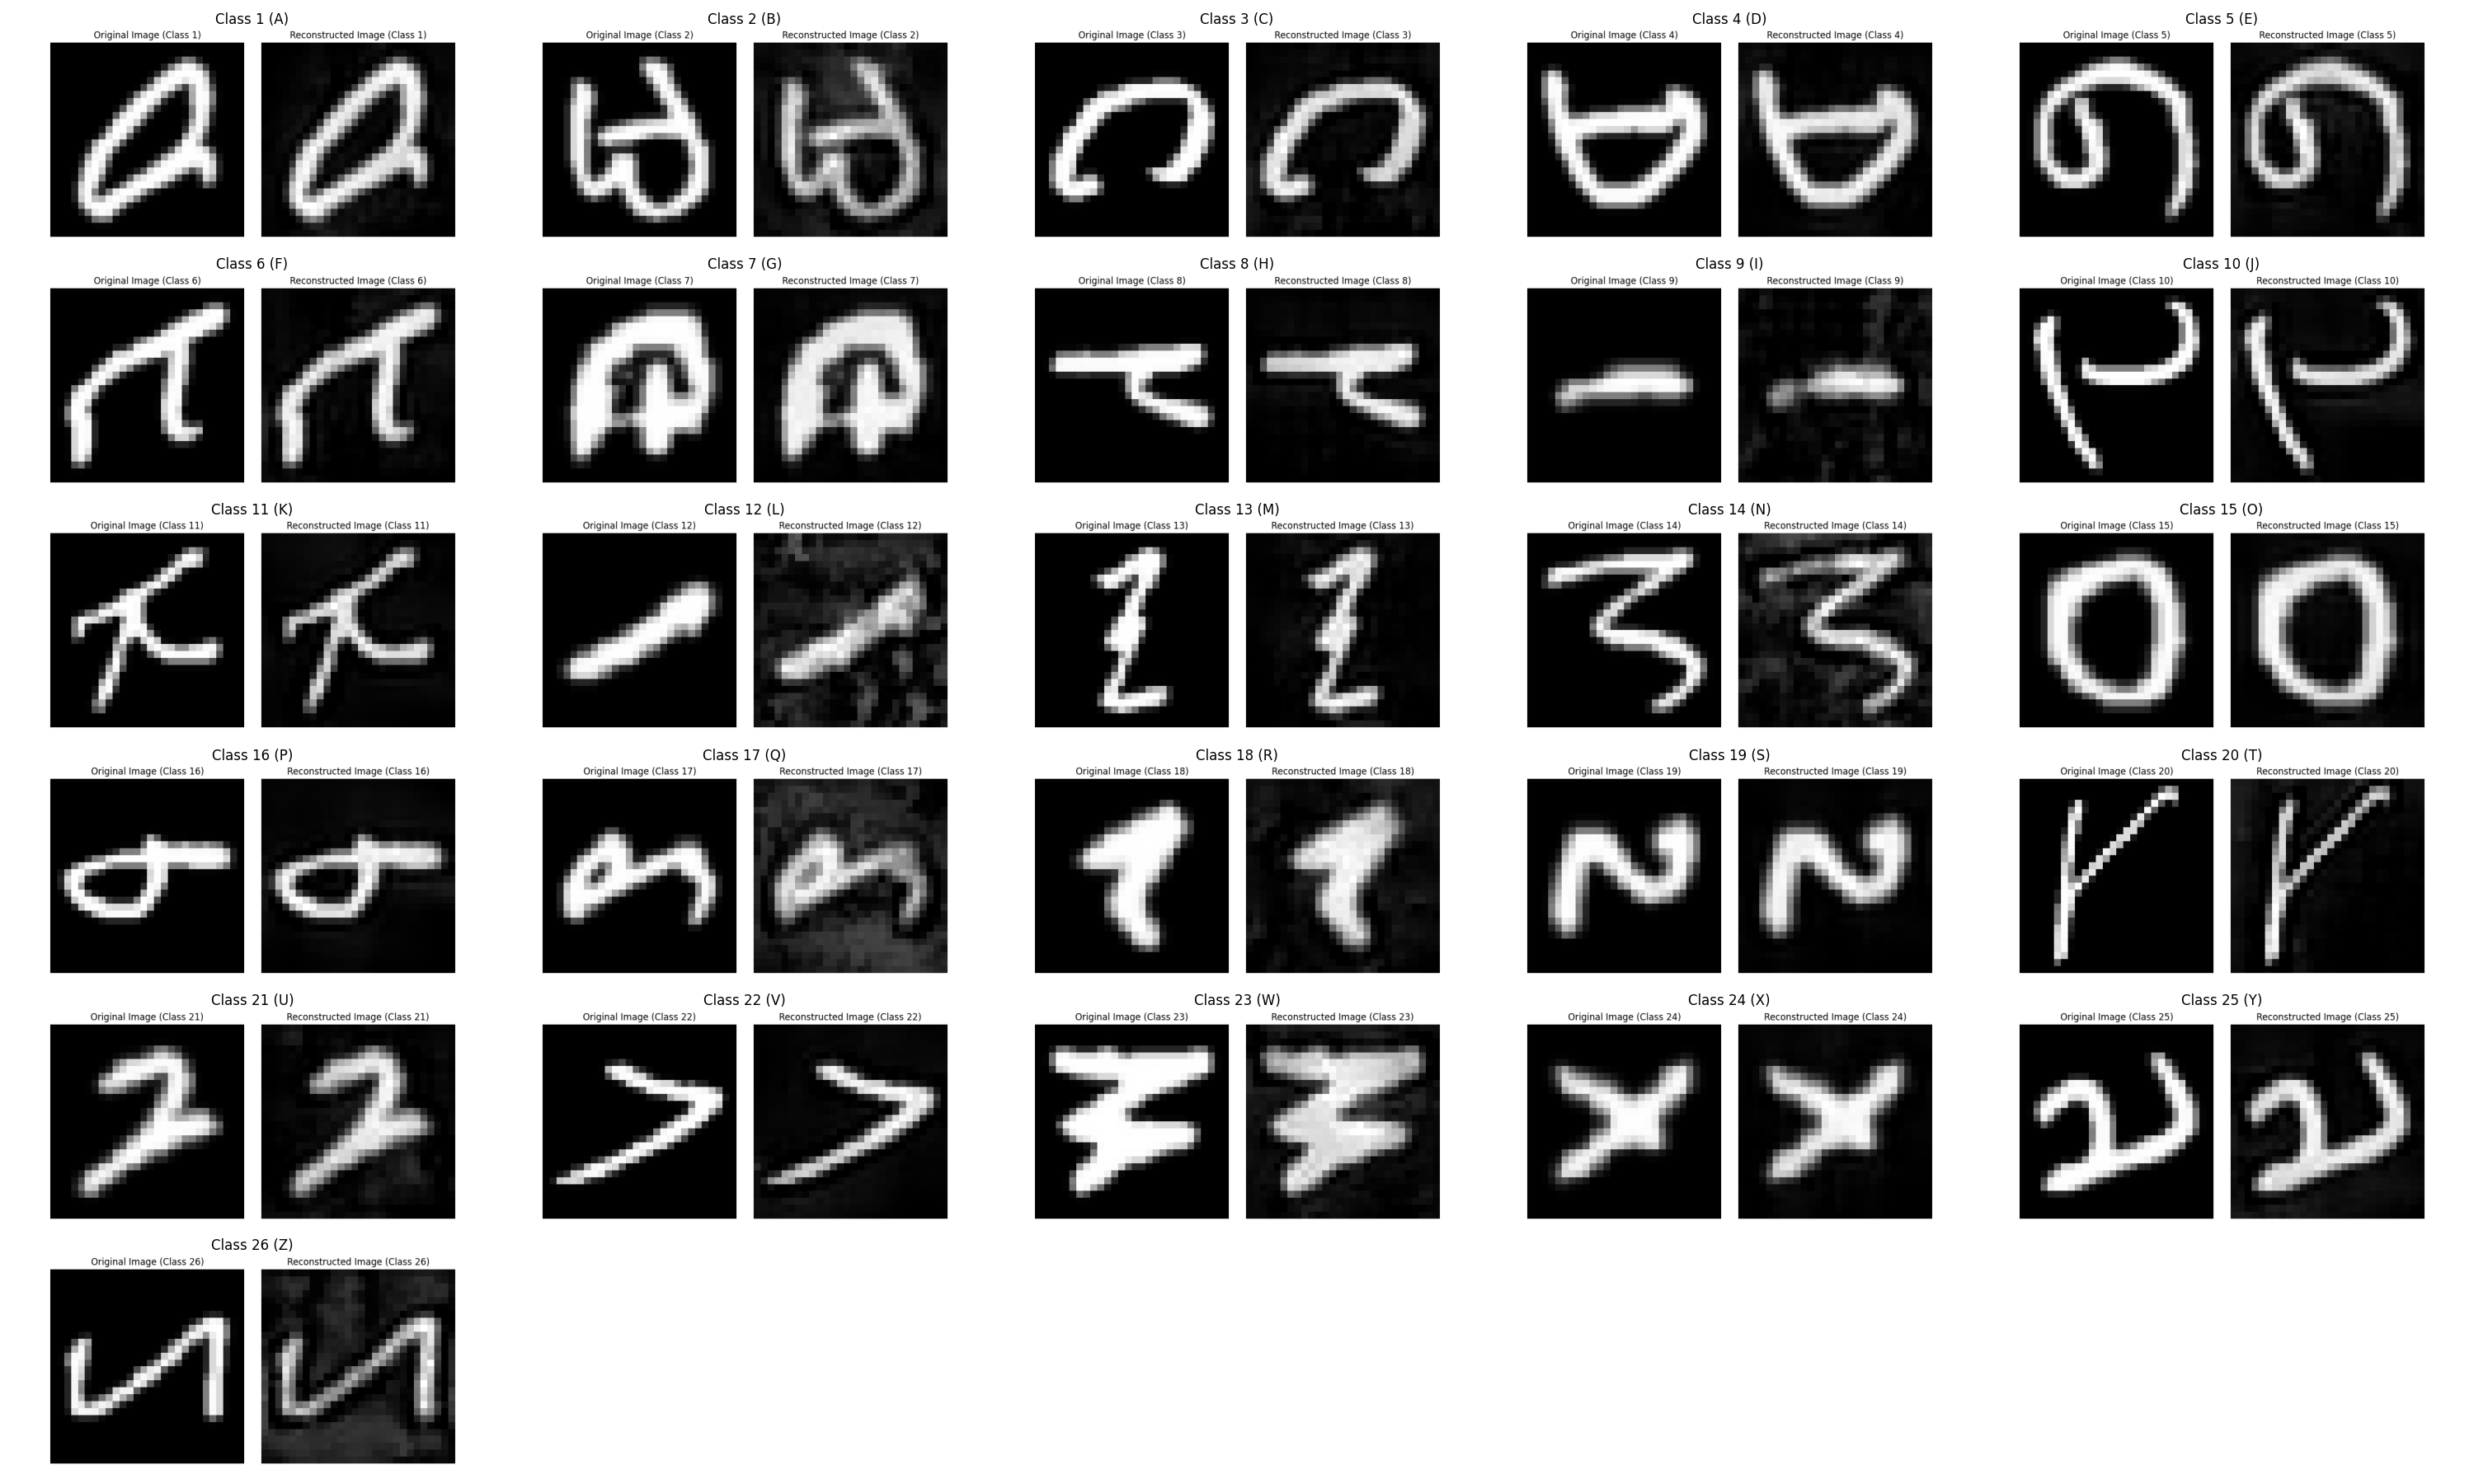

In [12]:
import matplotlib.pyplot as plt
import os
from IPython.display import Image, display

# Set up matplotlib backend for non-interactive plotting
import matplotlib
matplotlib.use('Agg')  # Use Agg backend for headless environments

# Parameters for the collage
n_classes = 26  # Number of classes (A-Z)
n_cols = 5  # Number of columns in the collage
n_rows = (n_classes + n_cols - 1) // n_cols  # Calculate rows needed (6 rows for 26 classes)

# Create a figure for the collage
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 3))
axes = axes.flatten()

# Loop over all classes (1 to 26 for A-Z)
for idx, target_label in enumerate(range(1, 27)):
    print(f"\nProcessing comparison image for class {target_label} (Letter {chr(64 + target_label)})...")

    # Path to the comparison image
    image_path = f'/content/emnist_comparison_class_{target_label}.png'

    # Check if the image exists
    if os.path.exists(image_path):
        # Load and add the image to the collage
        img = plt.imread(image_path)
        axes[idx].imshow(img)
        axes[idx].set_title(f"Class {target_label} ({chr(64 + target_label)})")
        axes[idx].axis('off')
    else:
        print(f"Image not found at {image_path}")
        axes[idx].axis('off')

# Turn off any unused subplots
for idx in range(n_classes, len(axes)):
    axes[idx].axis('off')

# Save the collage
plt.tight_layout()
collage_path = '/content/comparison_collage_all.png'
plt.savefig(collage_path)
plt.close()

# Display the collage in the notebook
print("\nDisplaying the collage of all comparison images...")
display(Image(filename=collage_path))